In [120]:
import pandas as pd
import numpy as np

# read the json file public_cases.json
# [
"""   {
    "input": {
      "trip_duration_days": 3,
      "miles_traveled": 93,
      "total_receipts_amount": 1.42
    },
    "expected_output": 364.51
  }, """

# load duration, miles, receipts, and output into a pandas dataframe
df = pd.read_json('public_cases.json')
df = pd.json_normalize(df['input'])

# create new columns for the following features
# miles / duration, receipts / duration, r^2, m^2, d*m, d^2*m^2, log(d*r), log(m*r)
df['m/d'] = df['miles_traveled'] / df['trip_duration_days'].replace(0, 1)
df['r/d'] = df['total_receipts_amount'] / df['trip_duration_days'].replace(0, 1)
df['r^2'] = df['total_receipts_amount'] ** 2
df['m^2'] = df['miles_traveled'] ** 2
df['d*m'] = df['trip_duration_days'] * df['miles_traveled']
df['d^2*m^2'] = df['trip_duration_days'] ** 2 * df['miles_traveled'] ** 2
df['log(d*r)'] = np.log(df['trip_duration_days'] * df['total_receipts_amount'])
df['log(m*r)'] = np.log(df['miles_traveled'] * df['total_receipts_amount'])
df['log(r)'] = np.log(df['total_receipts_amount'].replace(0, 1))  # Avoid log(0) by replacing 0 with 1

# if reciepts ends in 49 or 99, set the cents_bug_flag to 1
df['cents_bug_flag'] = df['total_receipts_amount'].apply(lambda x: round(x % 1, 2) in [0.49, 0.99]).astype(int)

# flag for greater than 5 days
df['is_more_than_5_day_trip_flag'] = (df['trip_duration_days'] >= 5).astype(int)
df['is_5_day_trip_flag'] = (df['trip_duration_days'] == 5).astype(int)
df['is_8_day_trip_flag'] = (df['trip_duration_days'] == 8).astype(int)


""" # Avoid division by zero for trips with 0 days, though unlikely in this dataset.
df['miles_per_day'] = df['miles_traveled'] / df['trip_duration_days'].replace(0, 1)
df['receipts_per_day'] = df['total_receipts_amount'] / df['trip_duration_days'].replace(0, 1)

# Feature for tiered mileage calculation
# Let's use the rates Lisa mentioned: $0.58 for the first 100 miles, and a lower rate after.
# We'll estimate the lower rate at $0.45 for this feature.
def calculate_tiered_mileage(miles):
    if miles > 100:
        return (100 * 0.58) + ((miles - 100) * 0.45)
    else:
        return miles * 0.58

df['tiered_mileage_feature'] = df['miles_traveled'].apply(calculate_tiered_mileage)

# Feature for Kevin's efficiency sweet spot
df['efficiency_bonus_flag'] = df['miles_per_day'].between(180, 220, inclusive='both').astype(int)

# Feature for the 5-day bonus
df['is_5_day_trip_flag'] = (df['trip_duration_days'] == 5).astype(int)

# Feature for the general 4-6 day sweet spot
df['is_sweet_spot_duration_flag'] = df['trip_duration_days'].between(4, 6, inclusive='both').astype(int)

# Feature for the low-receipt penalty (for amounts between $0 and $50)
df['low_receipt_penalty_flag'] = ((df['total_receipts_amount'] > 0) & (df['total_receipts_amount'] < 50)).astype(int)

# Feature for the cents bug
# We check if the cents part of the receipt amount is 49 or 99.
df['cents_bug_flag'] = df['total_receipts_amount'].apply(lambda x: round(x % 1, 2) in [0.49, 0.99]).astype(int)

# Feature for Kevin's "sweet spot combo"
# 5-day trips with 180+ miles/day and under $100/day in spending.
df['sweet_spot_combo_flag'] = ((df['trip_duration_days'] == 5) & 
                              (df['miles_per_day'] >= 180) & 
                              (df['receipts_per_day'] < 100)).astype(int)

# Feature for Kevin's "vacation penalty"
# 8+ day trips with high spending. Kevin suggests over $90/day for long trips.
df['vacation_penalty_flag'] = ((df['trip_duration_days'] >= 8) & 
                              (df['receipts_per_day'] > 90)).astype(int)"""

df['expected_output'] = pd.read_json('public_cases.json')['expected_output'] 


In [65]:
df.head()

trip_duration_days  miles_traveled  total_receipts_amount        m/d  \
0                   3            93.0                   1.42  31.000000   
1                   1            55.0                   3.60  55.000000   
2                   1            47.0                  17.97  47.000000   
3                   2            13.0                   4.67   6.500000   
4                   3            88.0                   5.78  29.333333   

         r/d       r^2     m^2    d*m  d^2*m^2  log(d*r)  log(m*r)  \
0   0.473333    2.0164  8649.0  279.0  77841.0  1.449269  4.883256   
1   3.600000   12.9600  3025.0   55.0   3025.0  1.280934  5.288267   
2  17.970000  322.9209  2209.0   47.0   2209.0  2.888704  6.738851   
3   2.335000   21.8089   169.0   26.0    676.0  2.234306  4.106108   
4   1.926667   33.4084  7744.0  264.0  69696.0  2.853016  6.231740   

   expected_output  
0           364.51  
1           126.06  
2           128.91  
3           203.52  
4           380.37

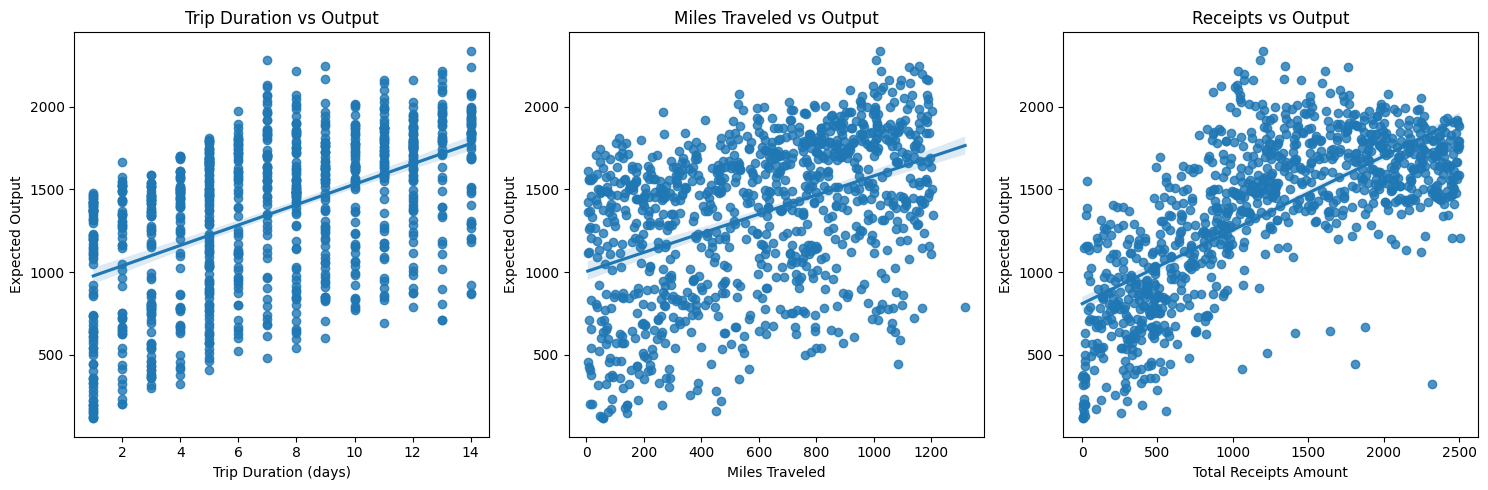

In [66]:
# plot duration vs output on a scatter plot and add a line of best fit
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot trip duration vs output
sns.regplot(data=df, x='trip_duration_days', y='expected_output', ax=ax1)
ax1.set_title('Trip Duration vs Output')
ax1.set_xlabel('Trip Duration (days)')
ax1.set_ylabel('Expected Output')

# Plot miles traveled vs output
sns.regplot(data=df, x='miles_traveled', y='expected_output', ax=ax2)
ax2.set_title('Miles Traveled vs Output')
ax2.set_xlabel('Miles Traveled')
ax2.set_ylabel('Expected Output')

# Plot receipts vs output
sns.regplot(data=df, x='total_receipts_amount', y='expected_output', ax=ax3)
ax3.set_title('Receipts vs Output')
ax3.set_xlabel('Total Receipts Amount')
ax3.set_ylabel('Expected Output')

plt.tight_layout()
plt.show()


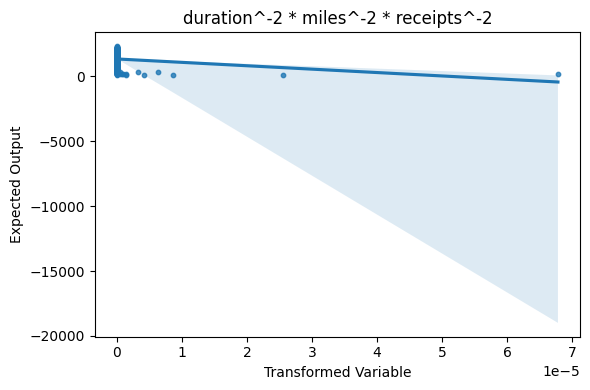

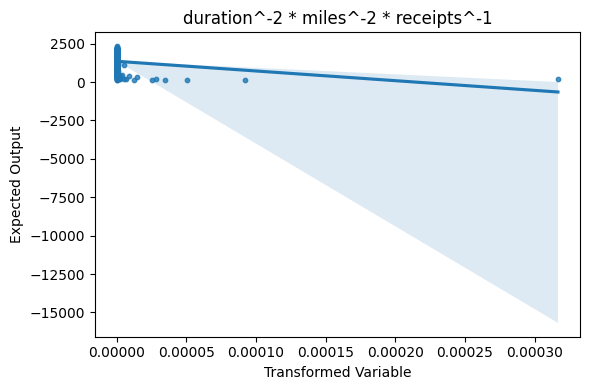

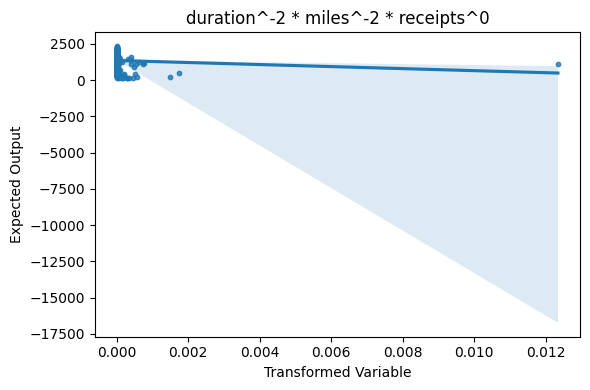

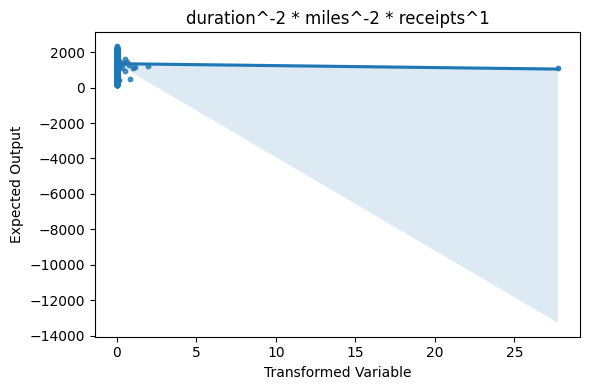

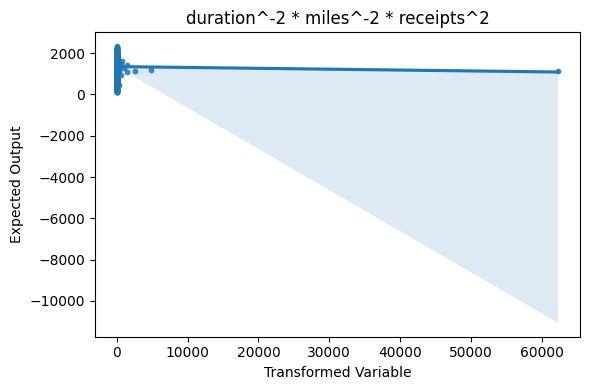

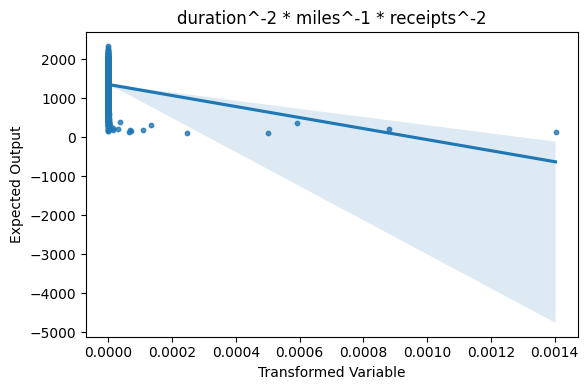

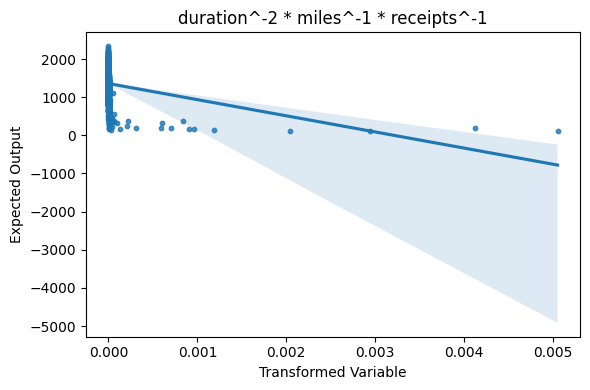

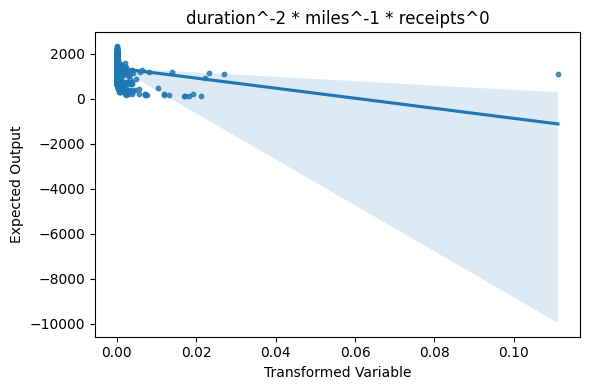

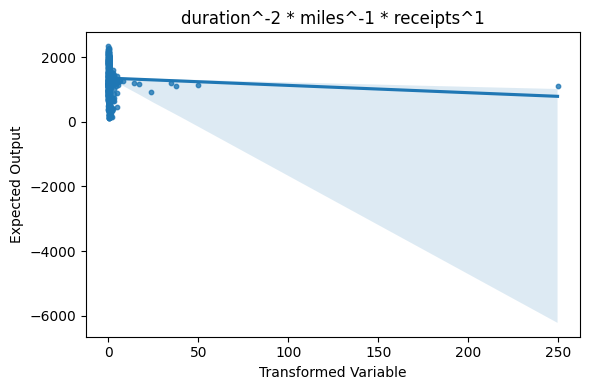

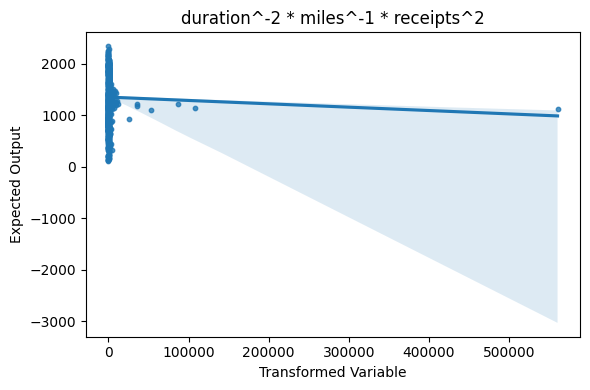

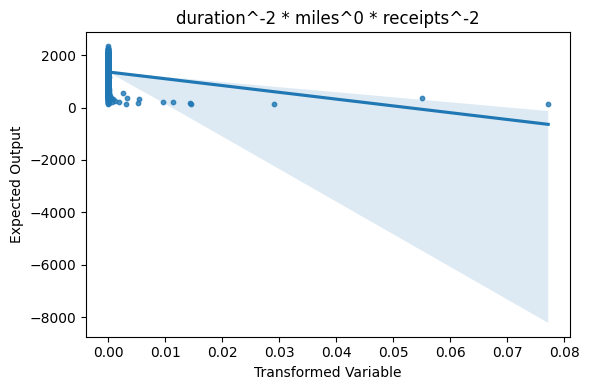

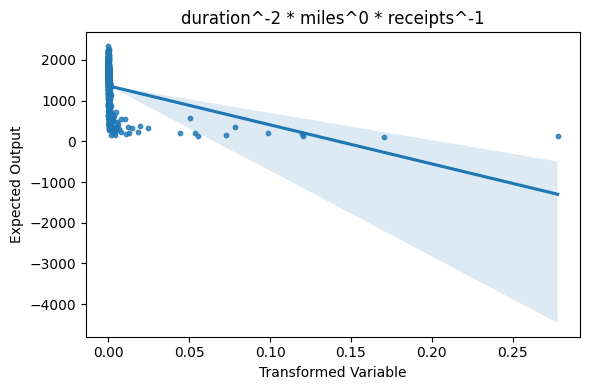

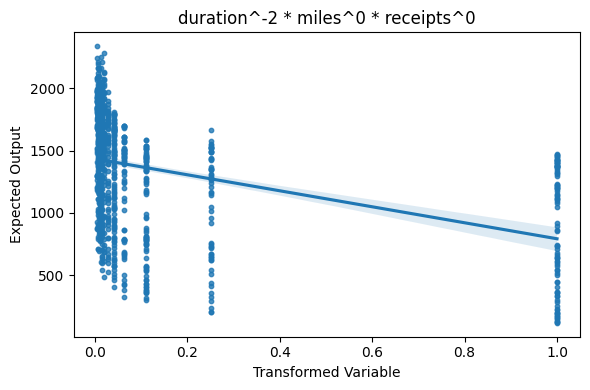

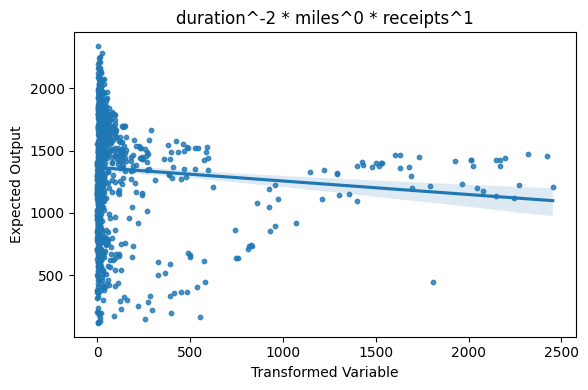

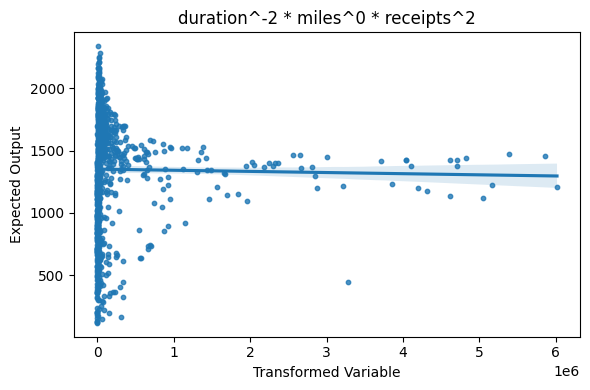

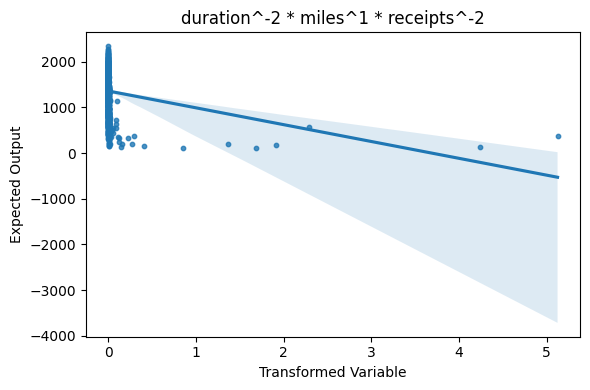

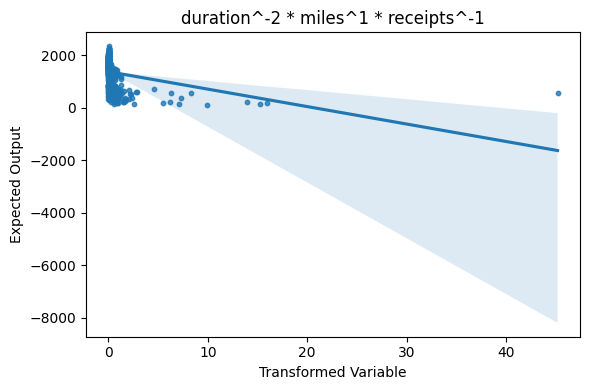

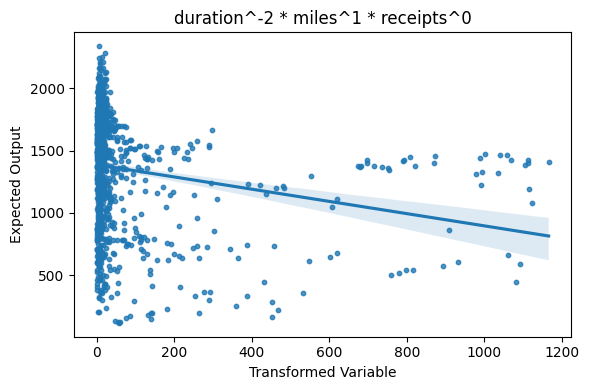

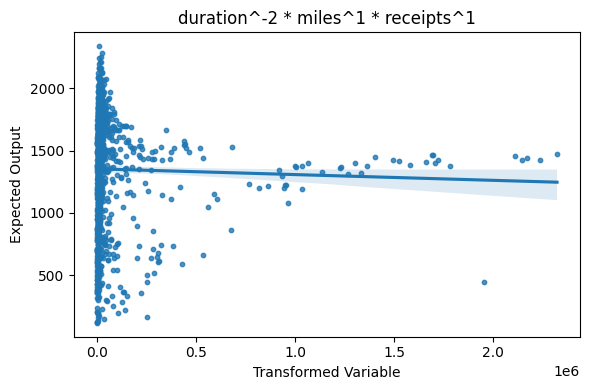

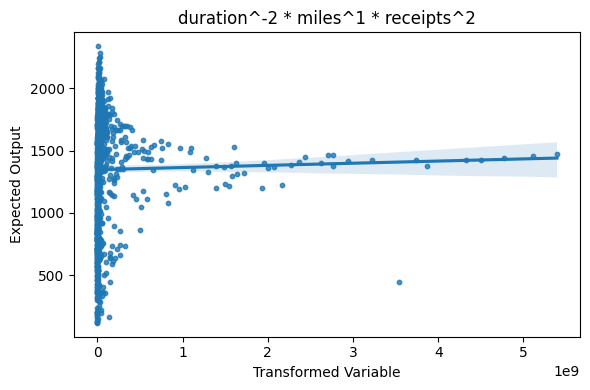

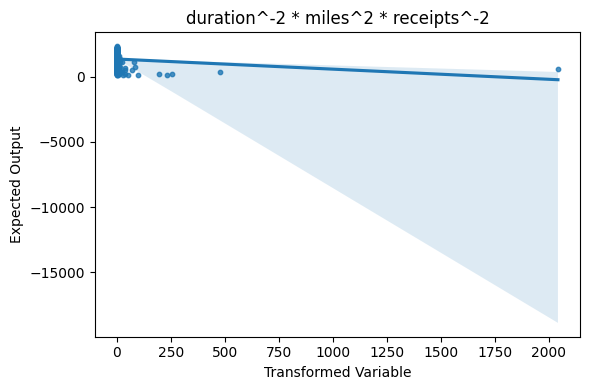

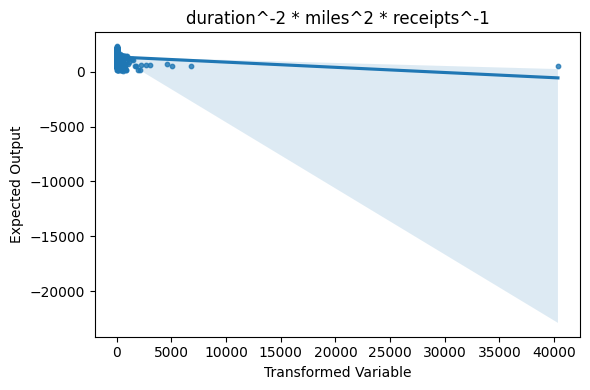

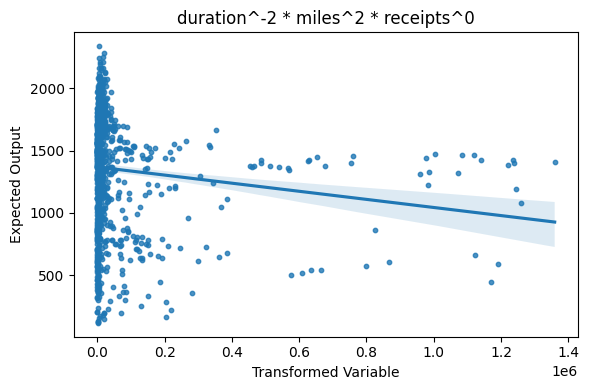

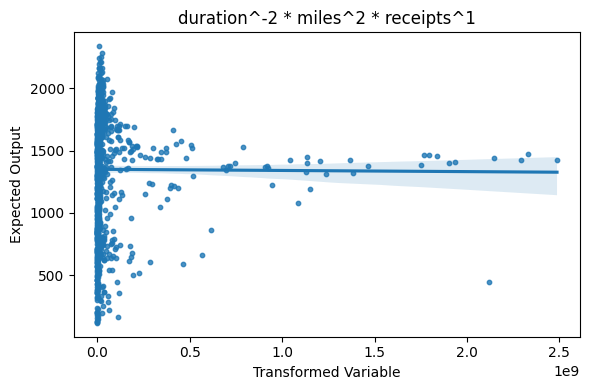

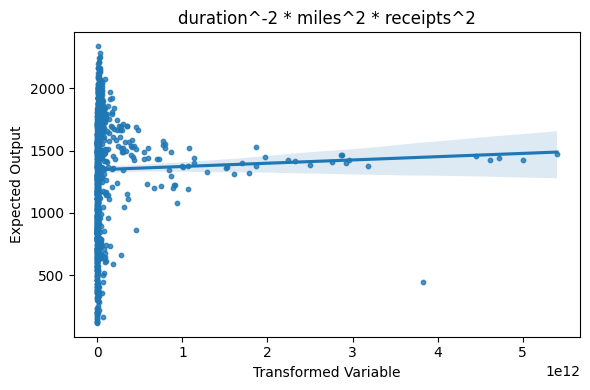

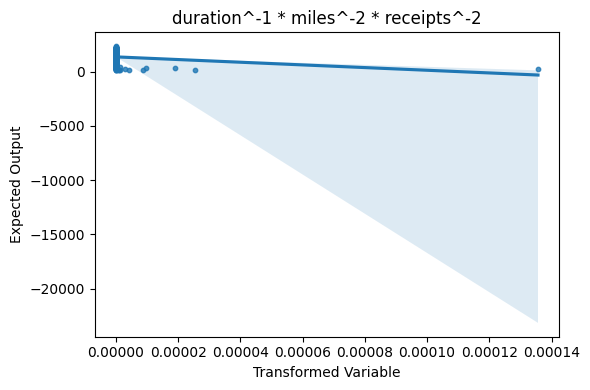

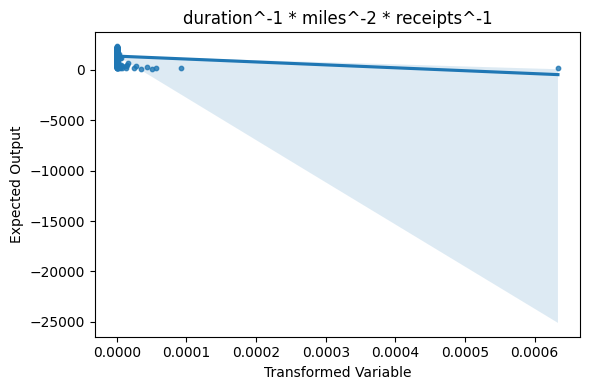

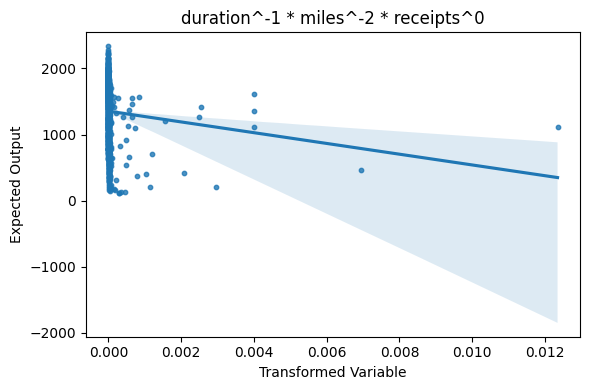

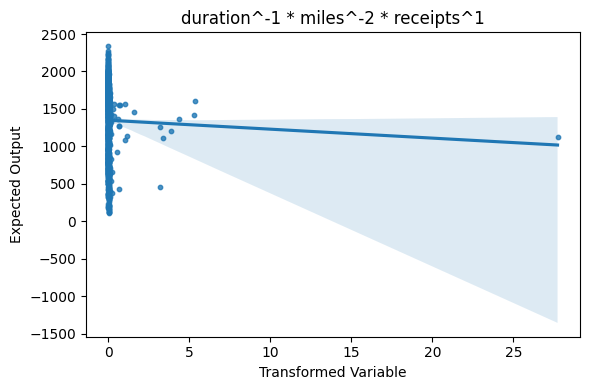

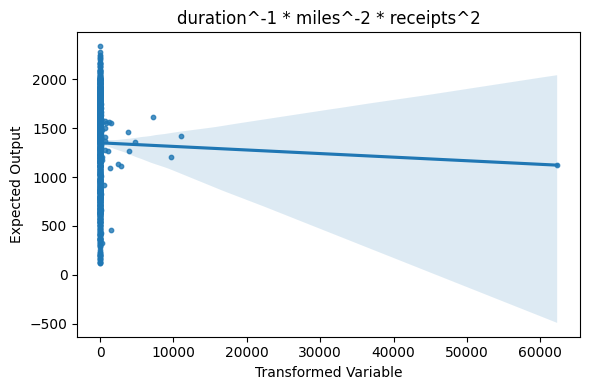

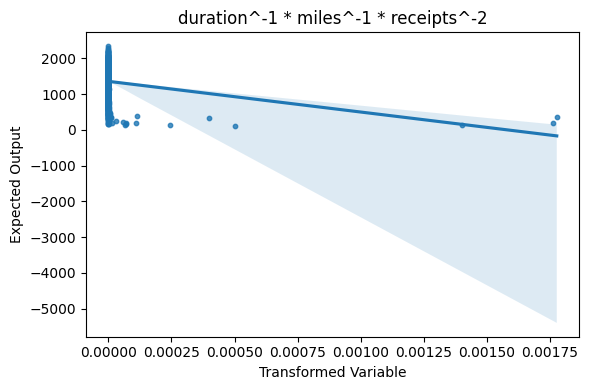

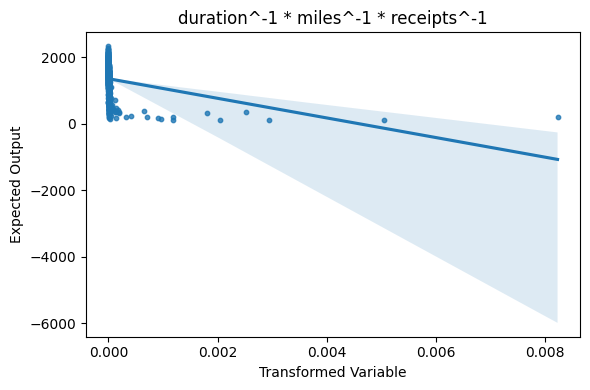

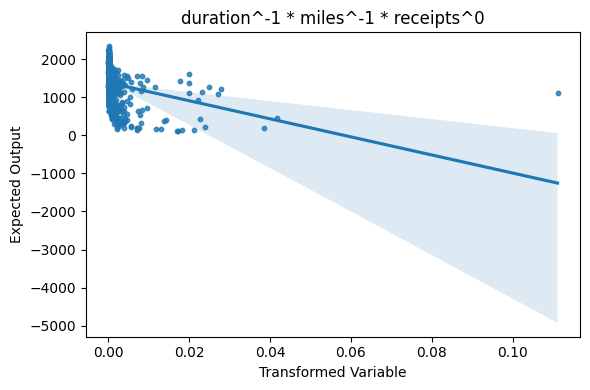

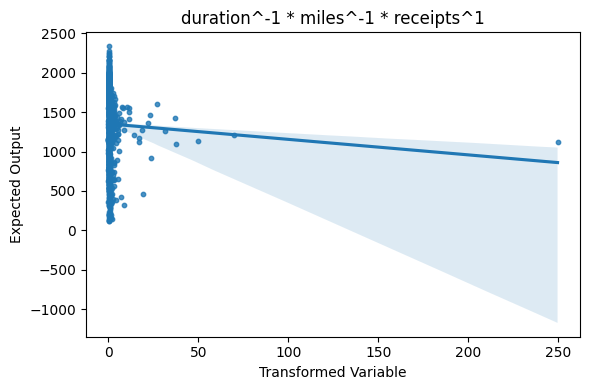

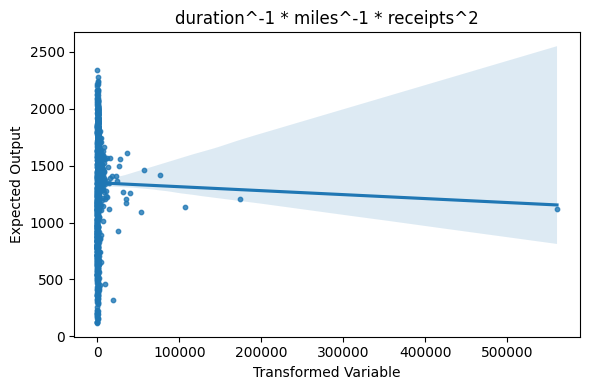

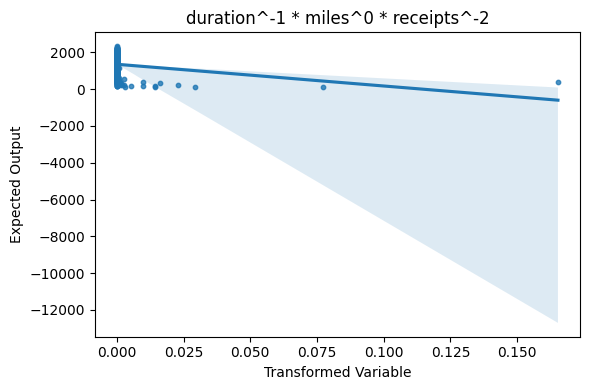

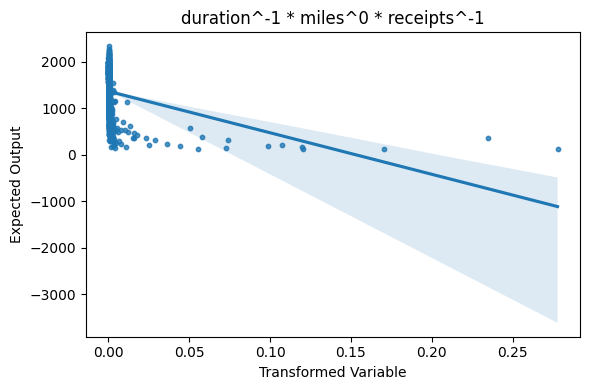

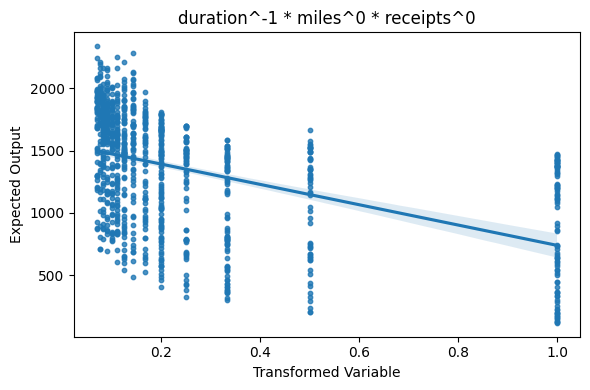

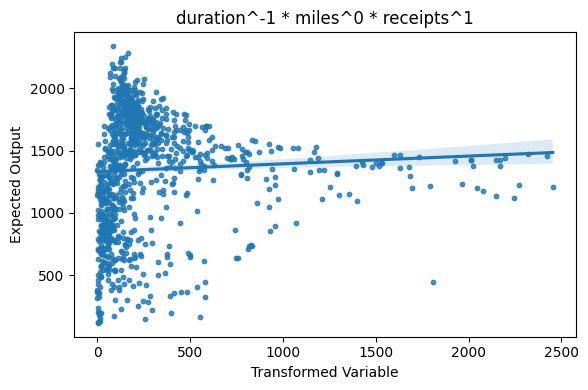

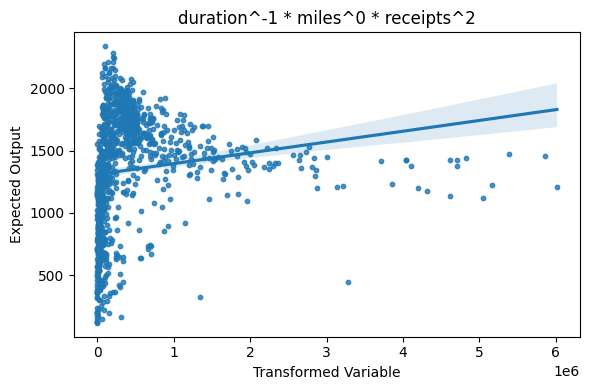

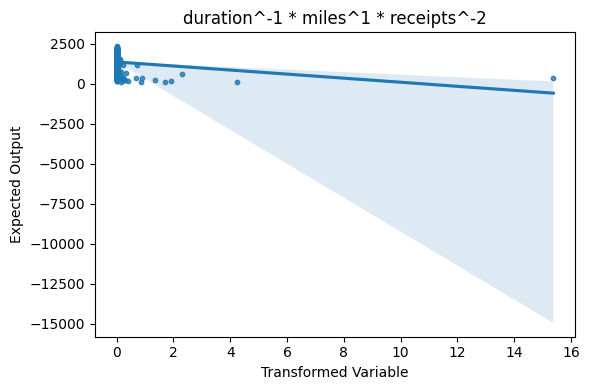

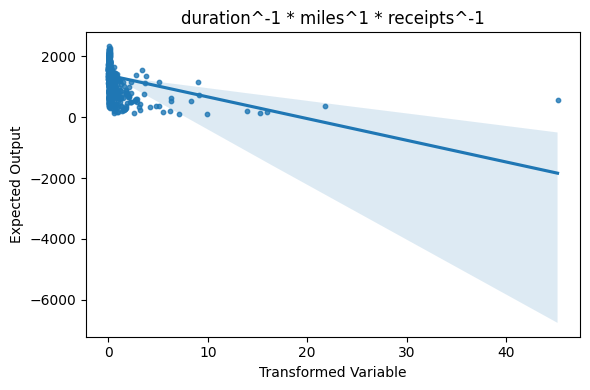

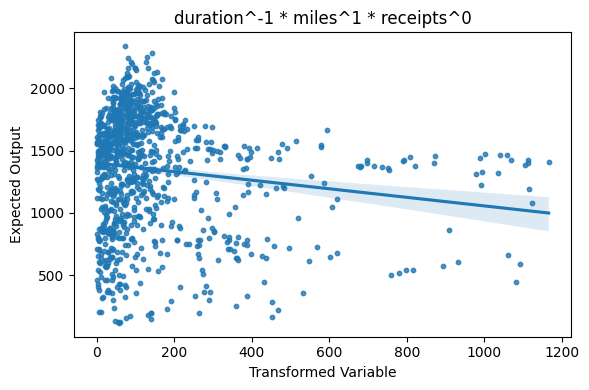

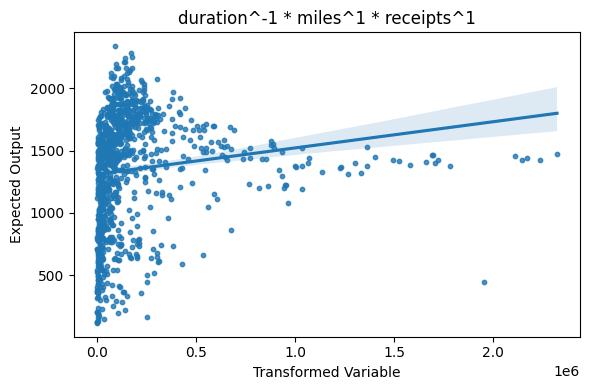

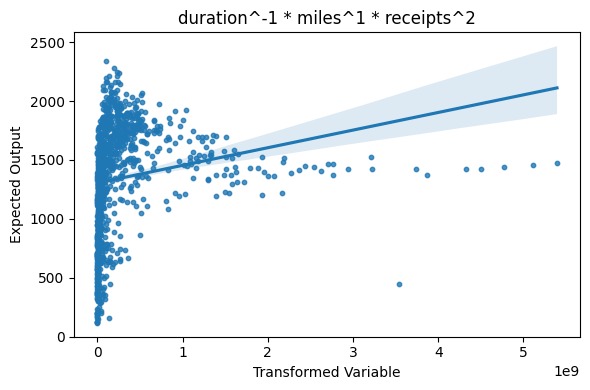

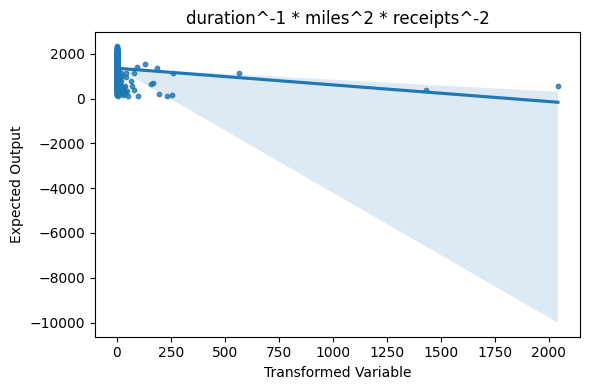

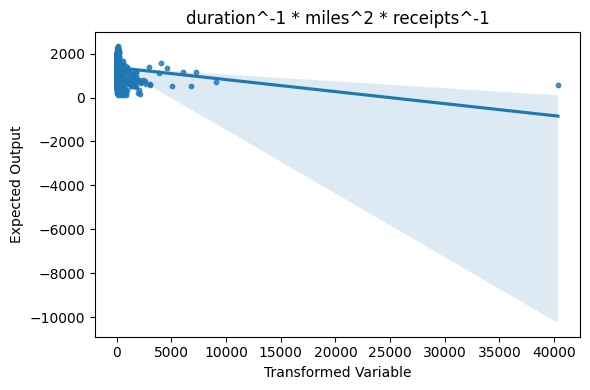

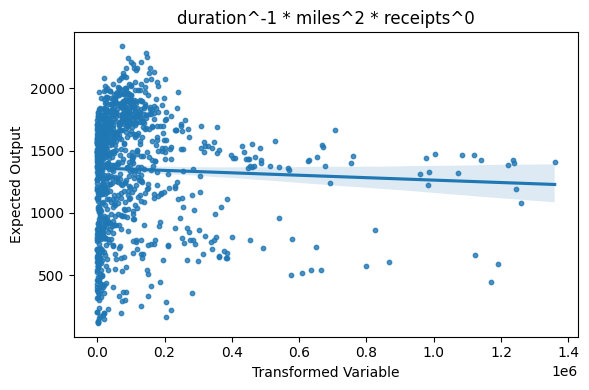

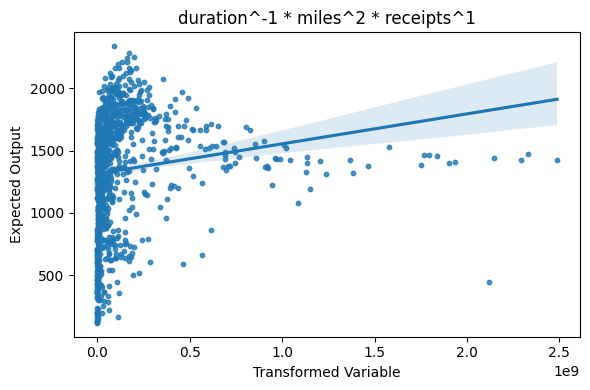

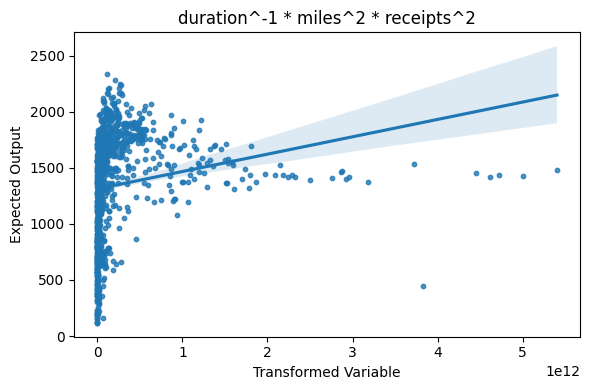

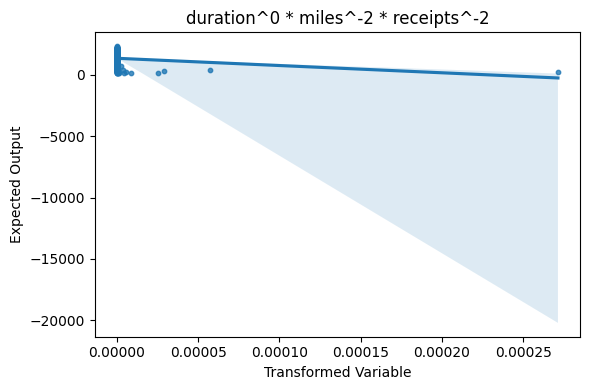

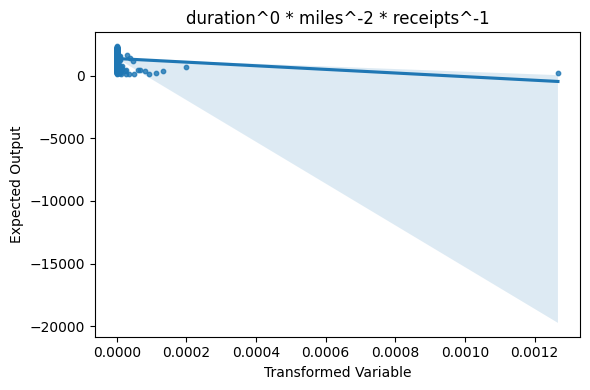

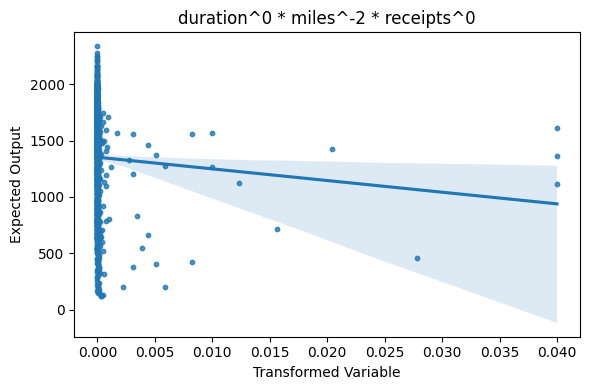

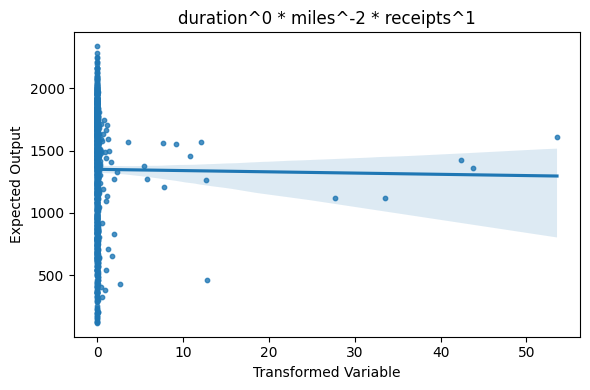

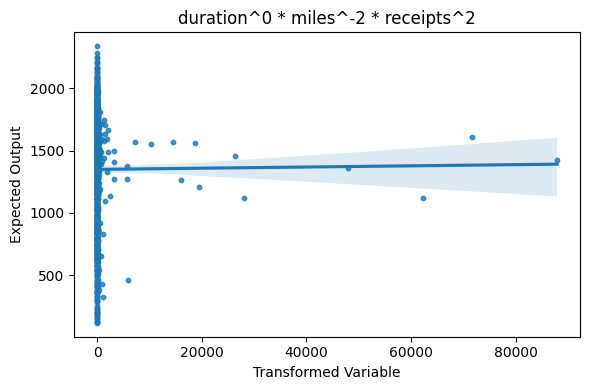

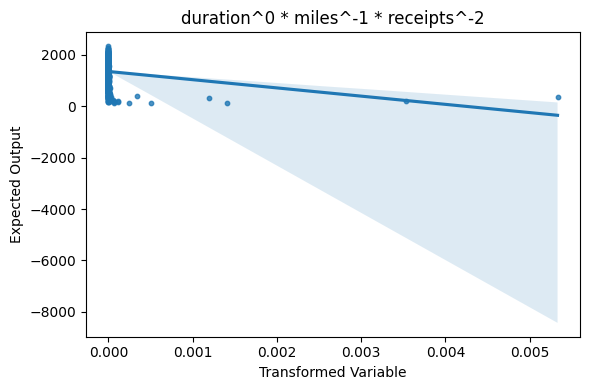

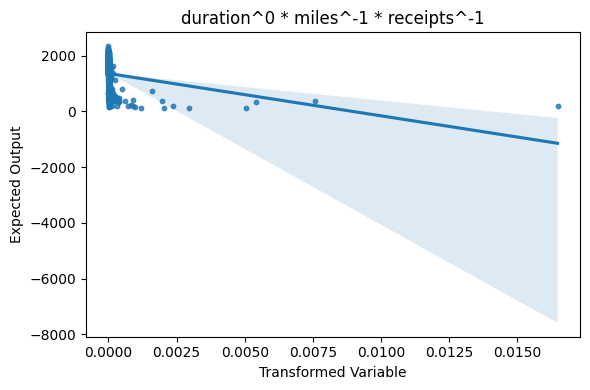

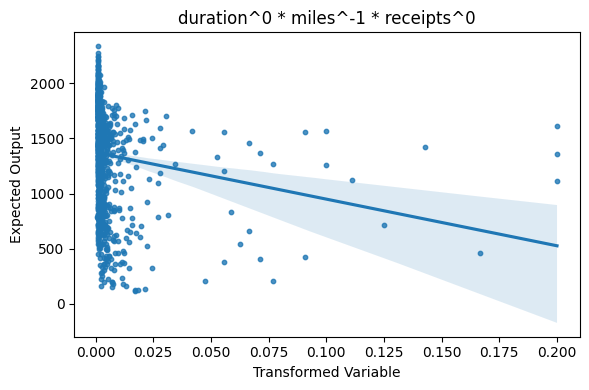

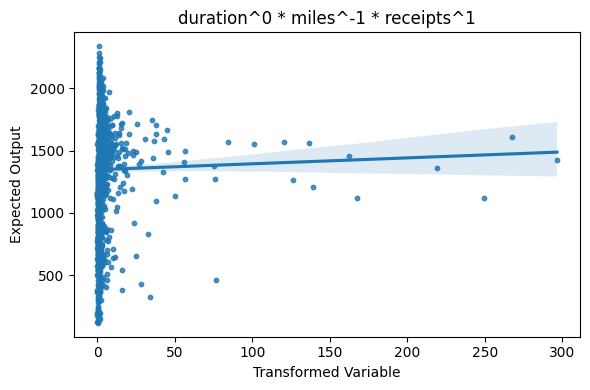

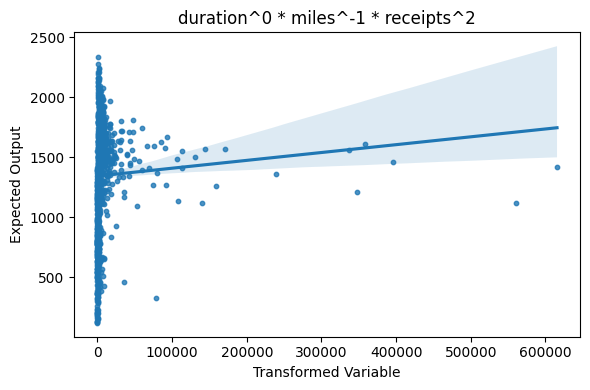

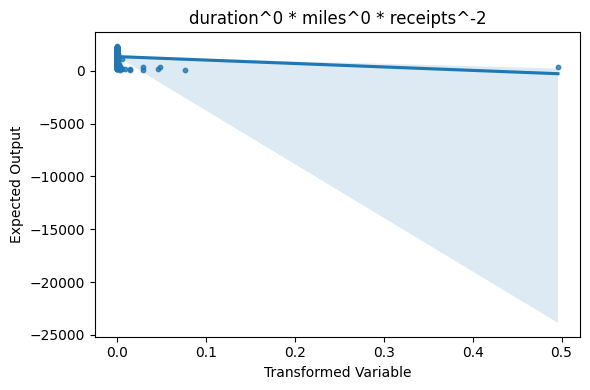

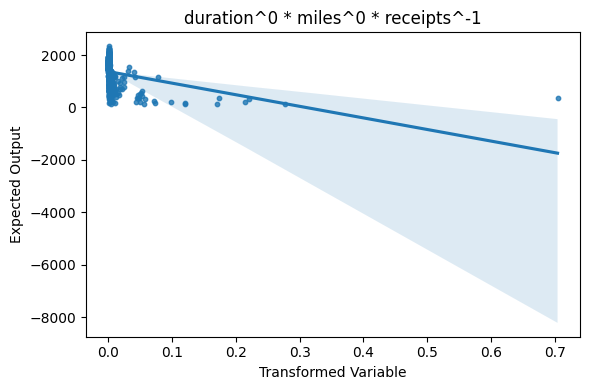

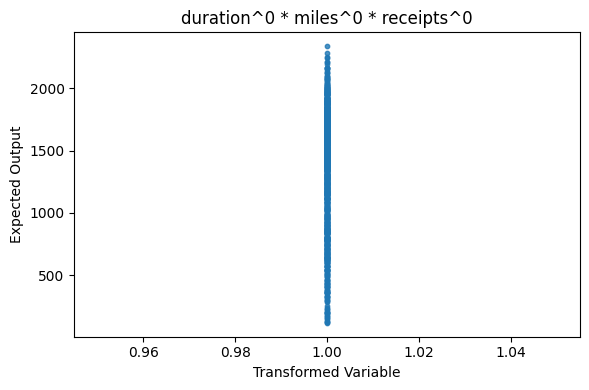

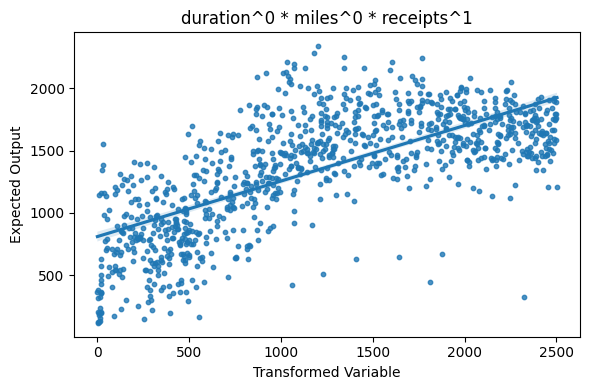

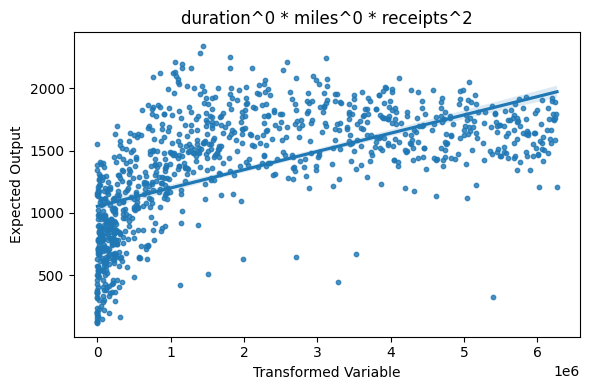

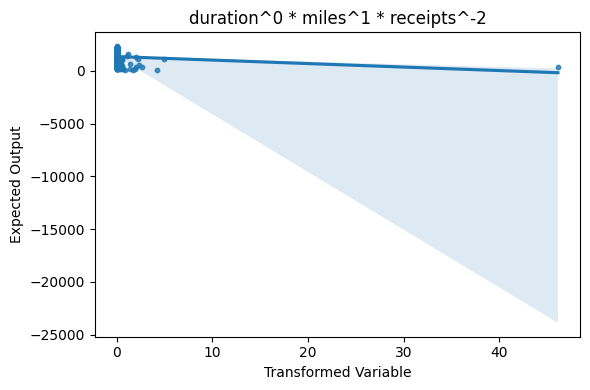

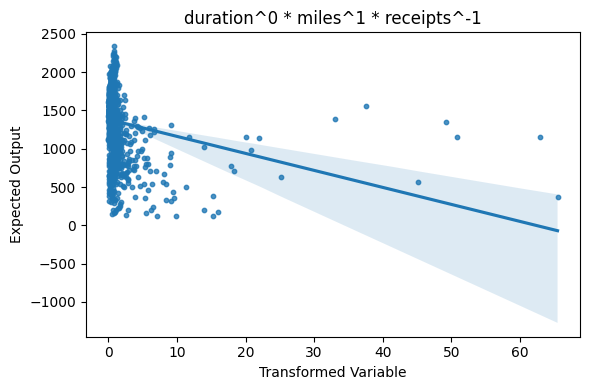

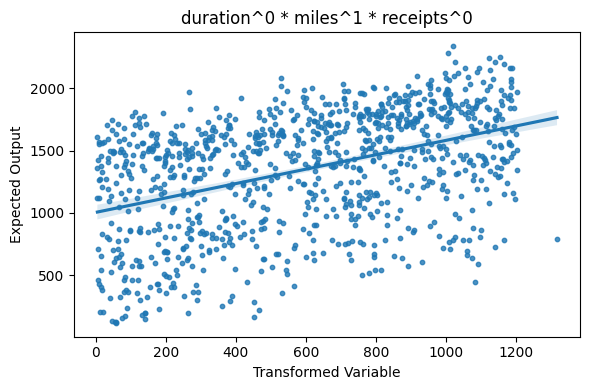

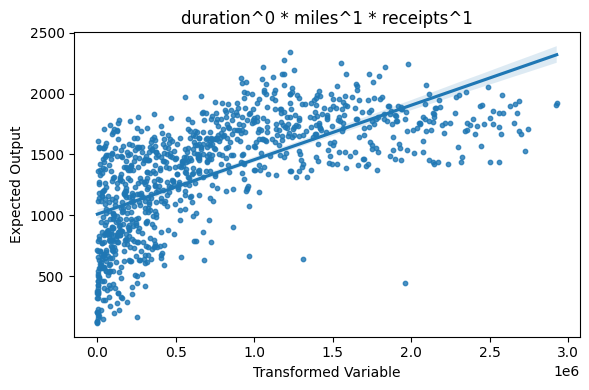

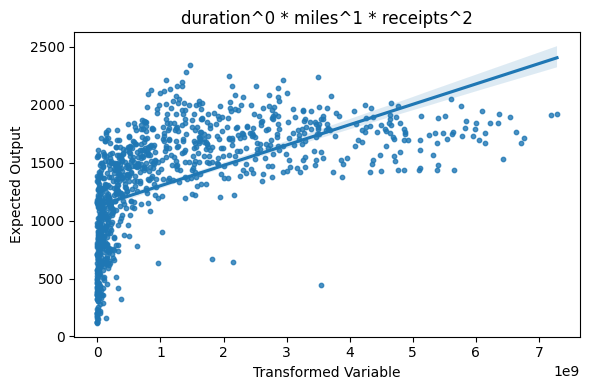

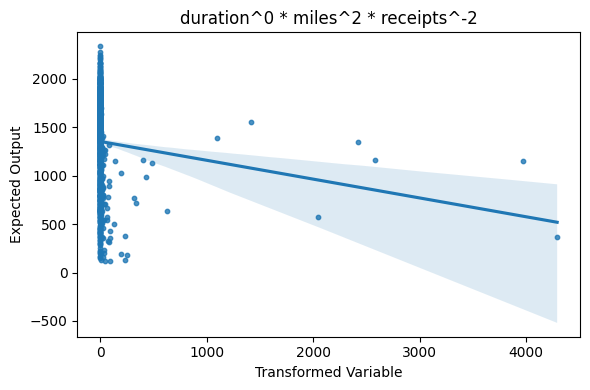

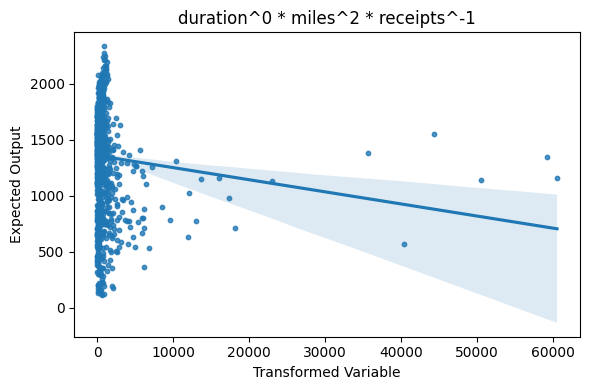

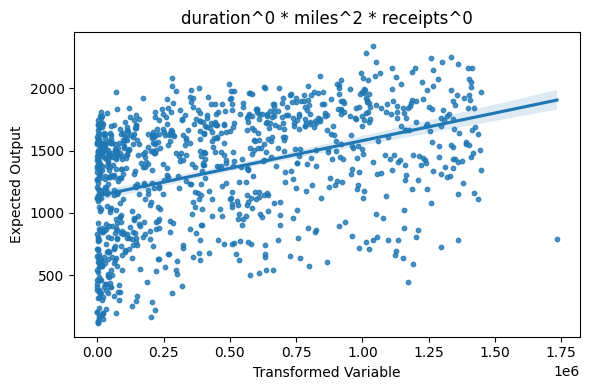

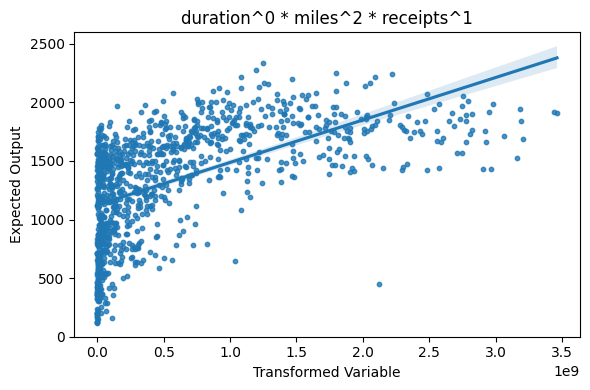

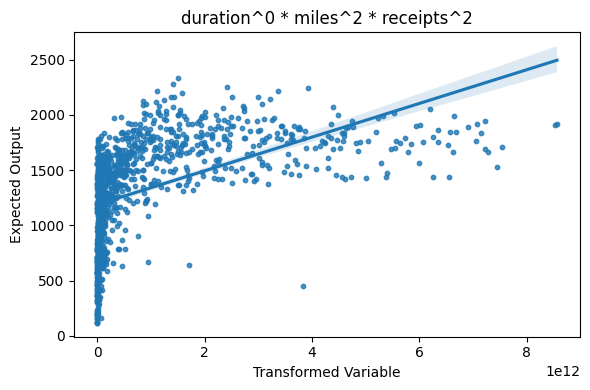

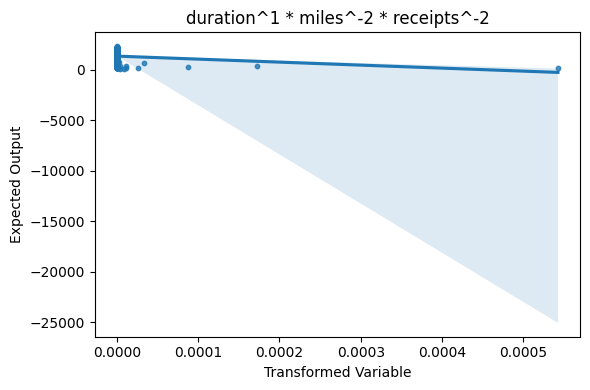

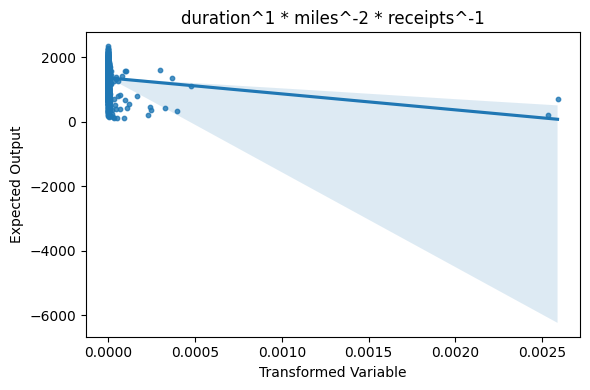

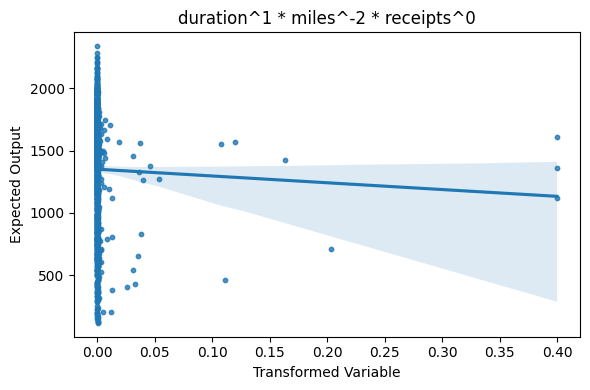

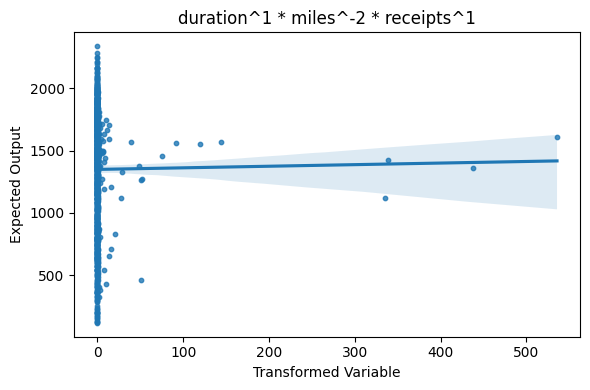

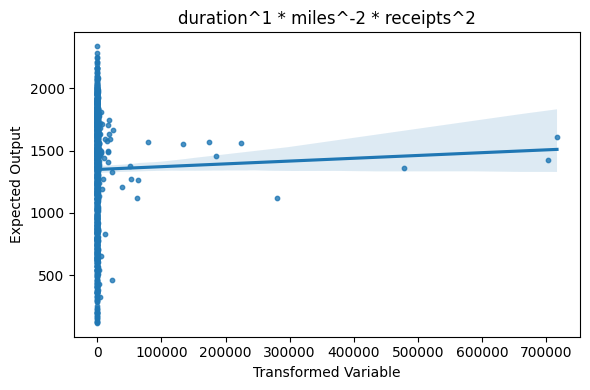

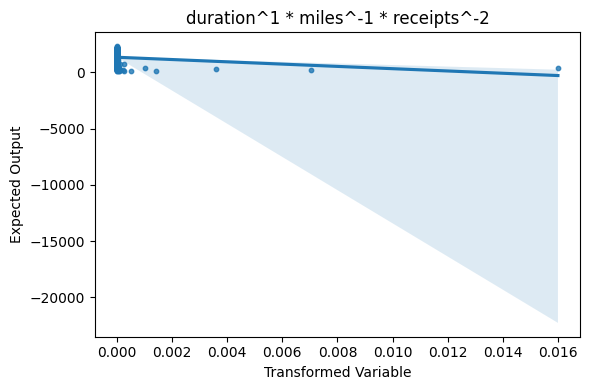

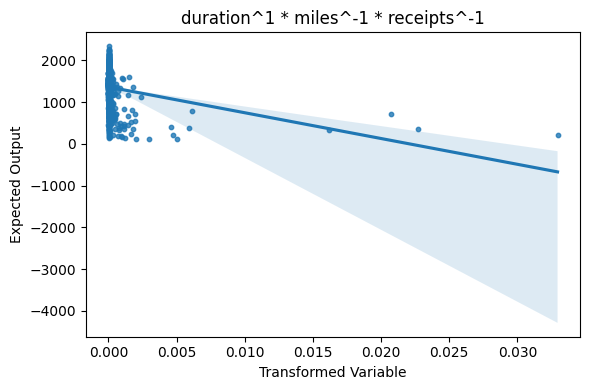

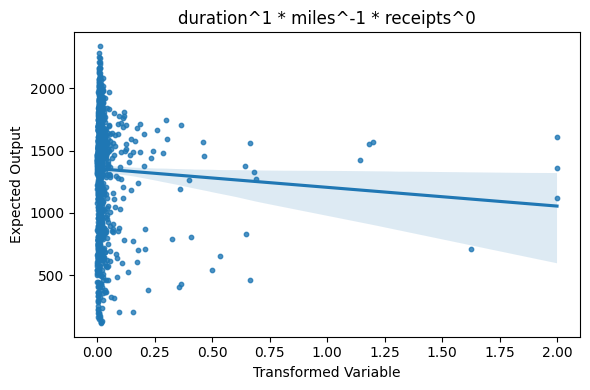

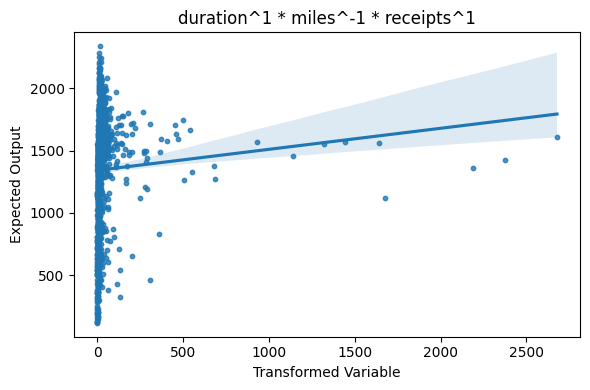

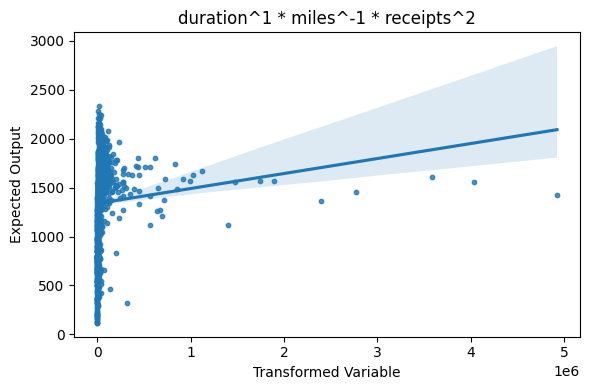

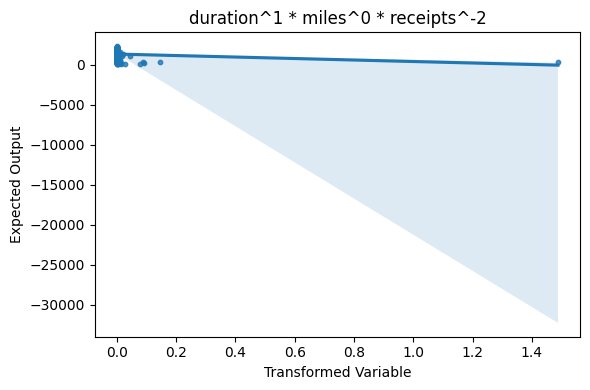

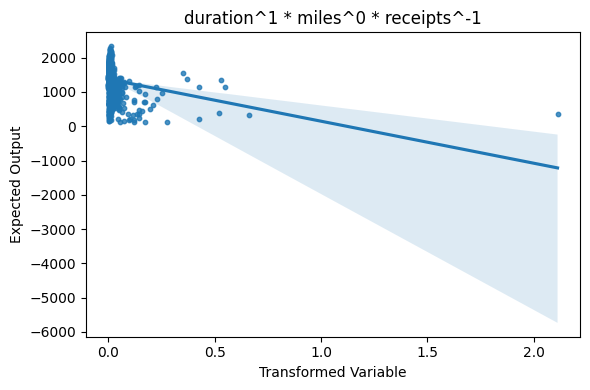

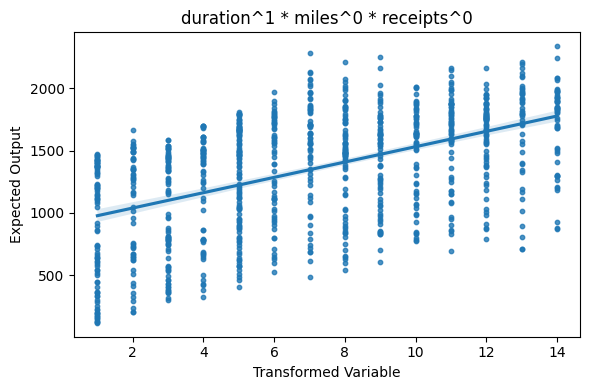

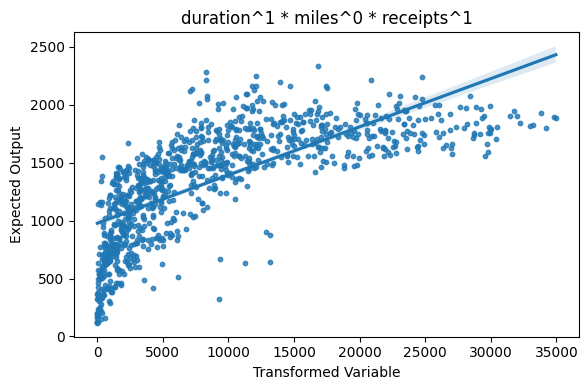

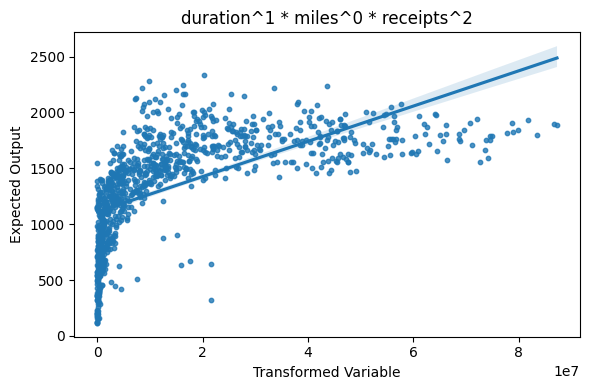

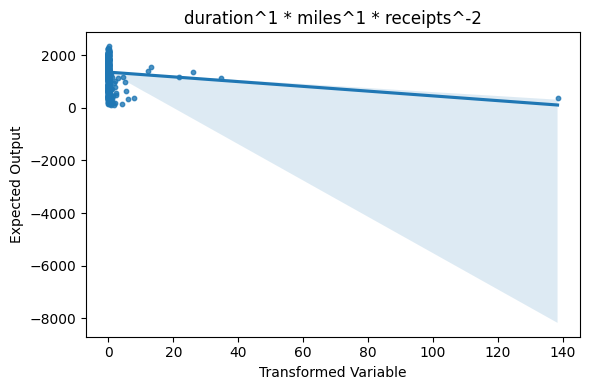

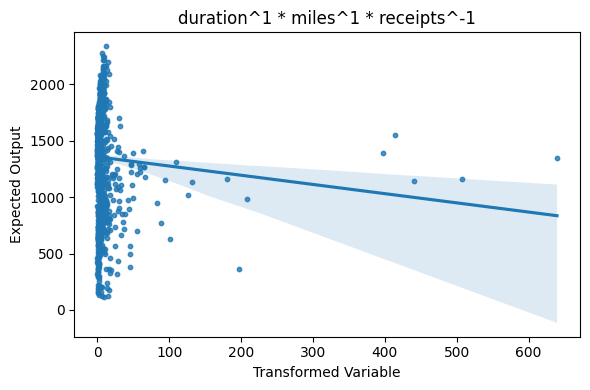

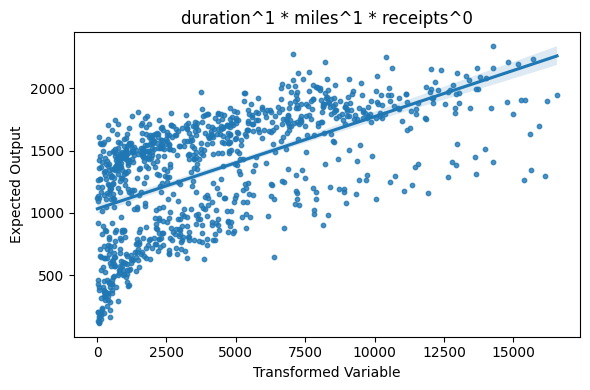

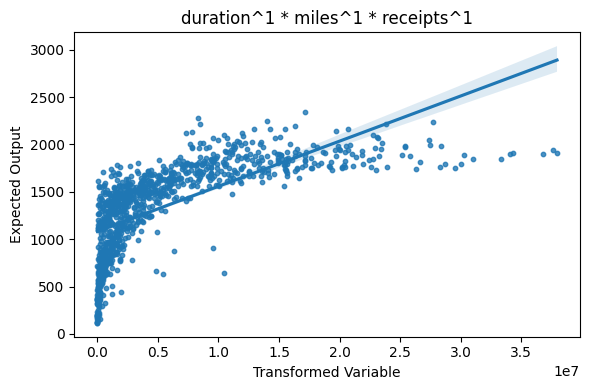

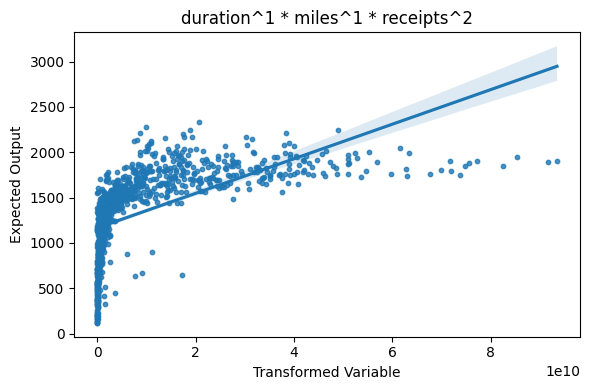

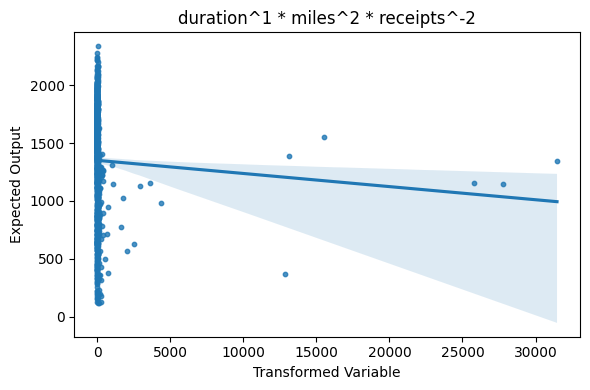

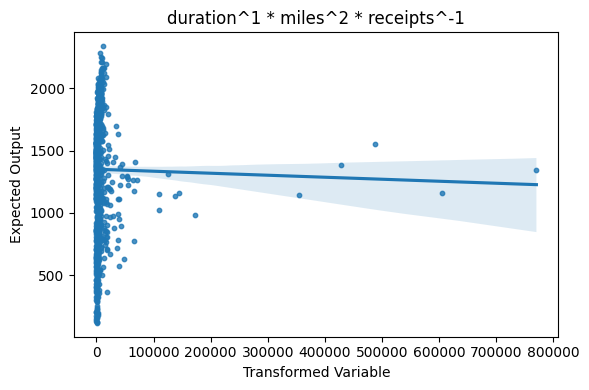

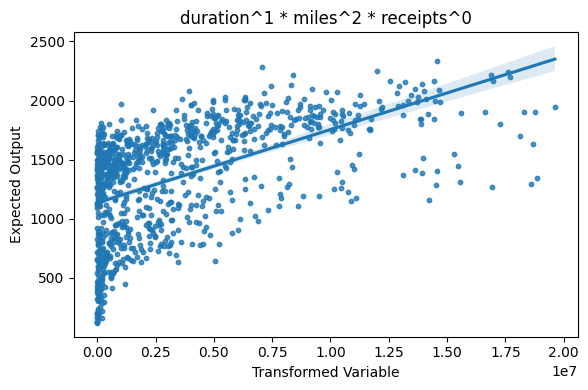

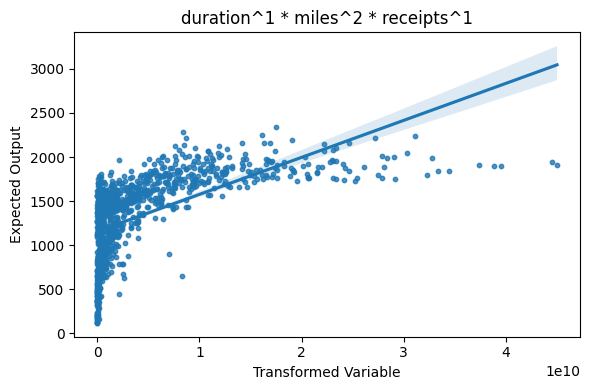

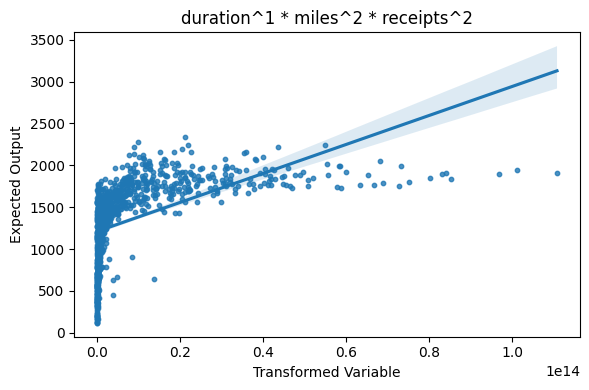

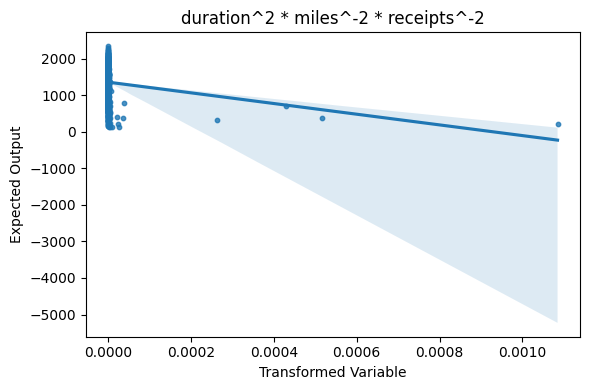

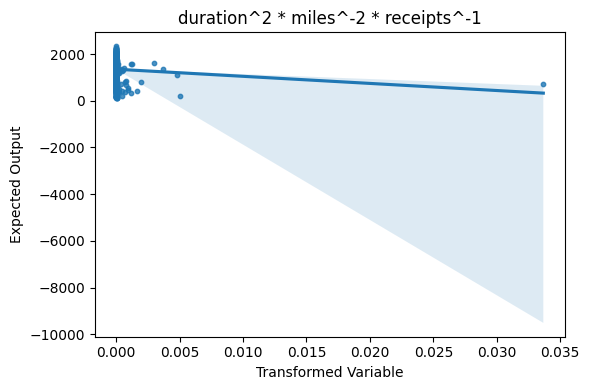

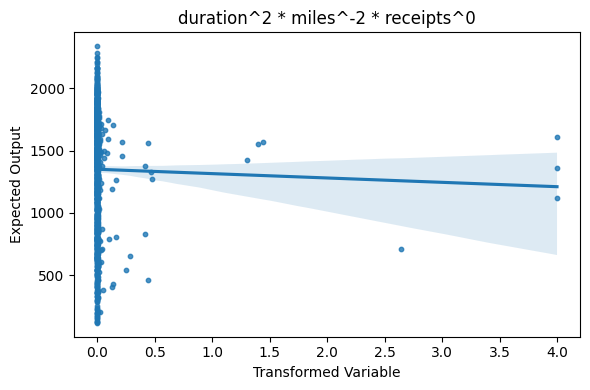

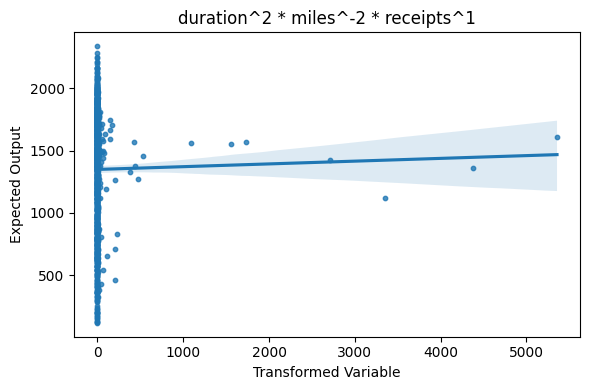

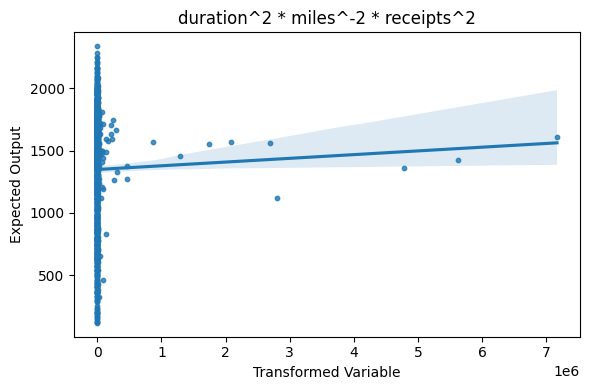

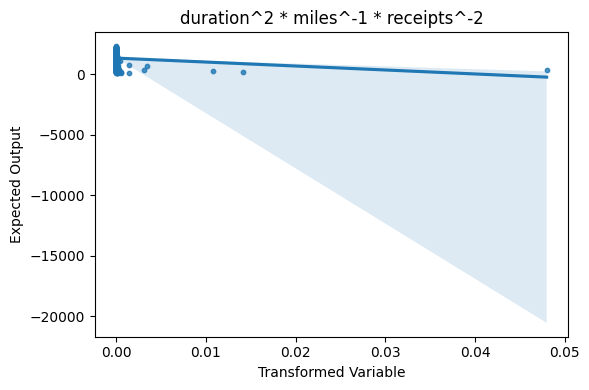

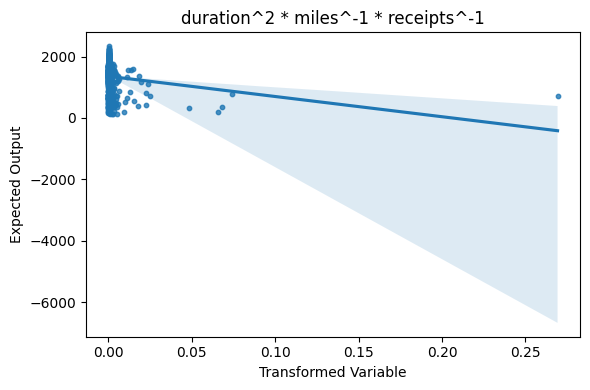

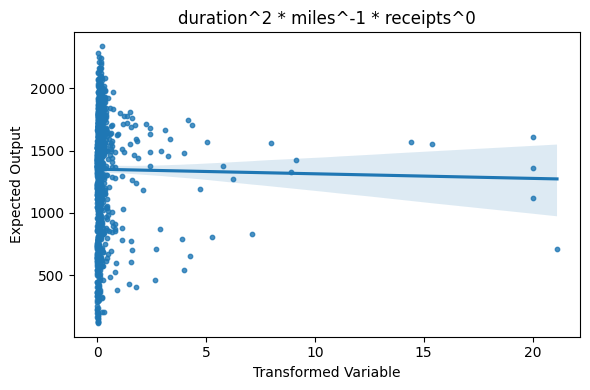

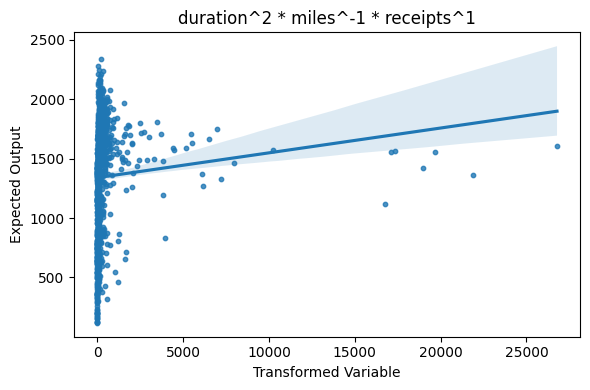

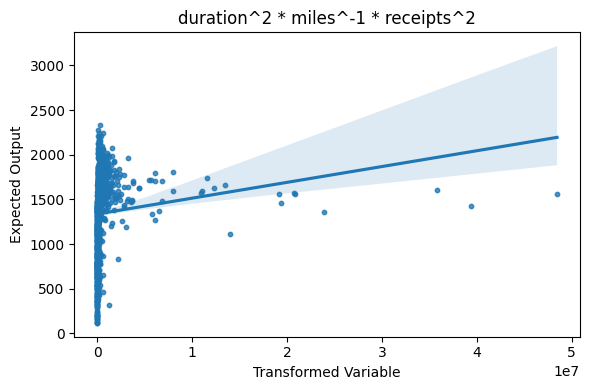

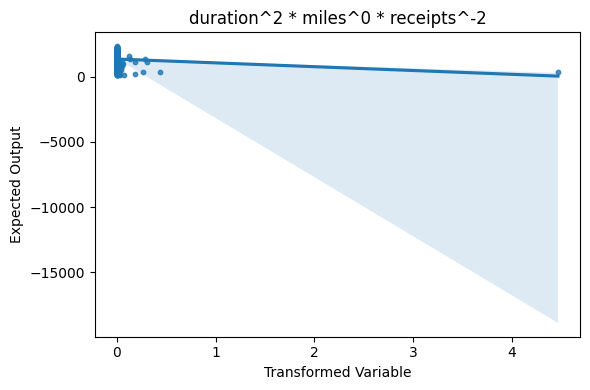

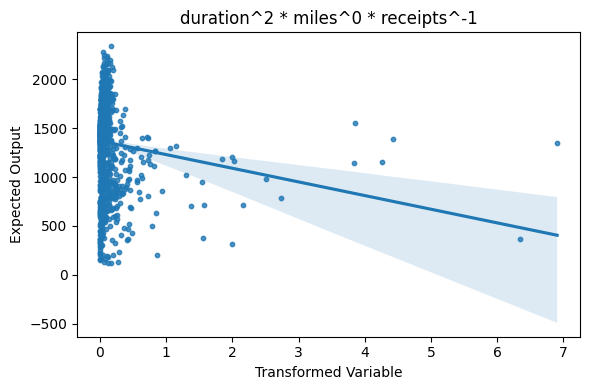

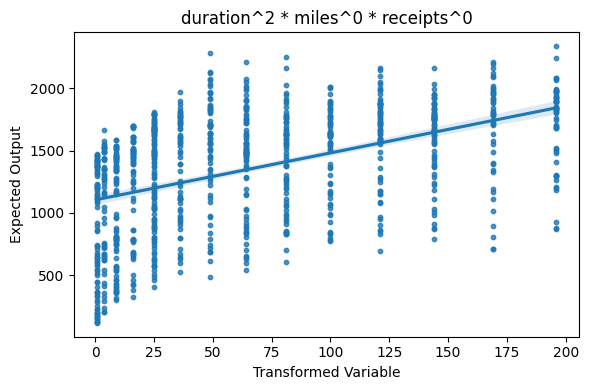

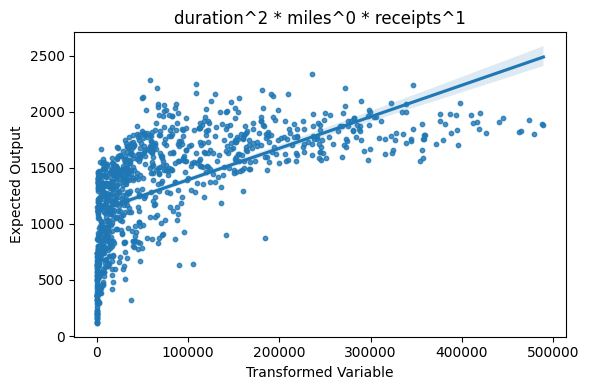

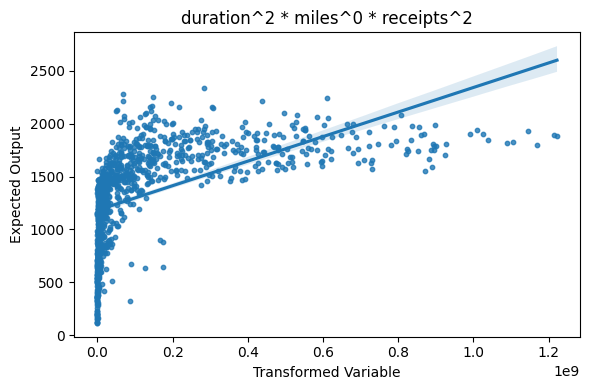

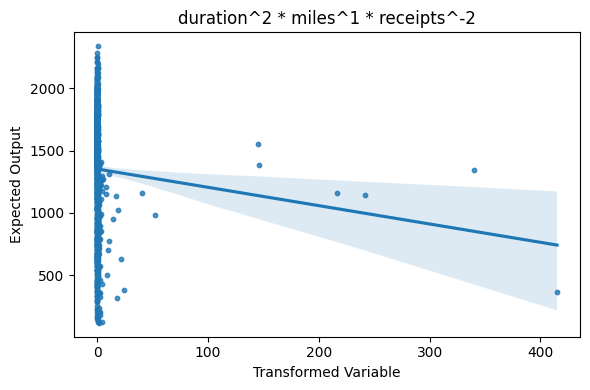

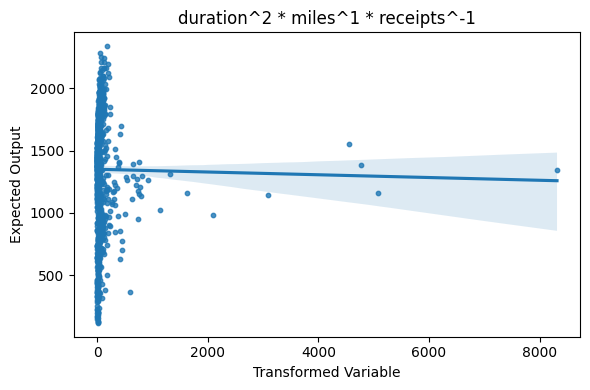

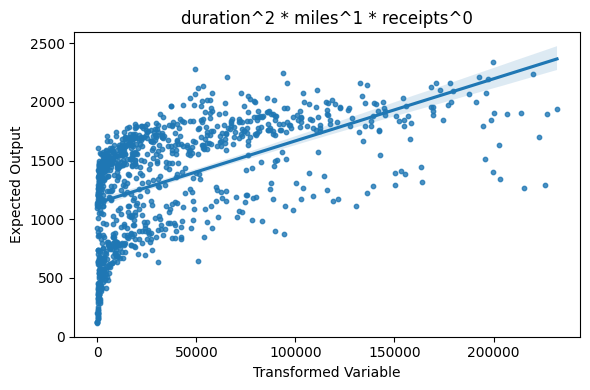

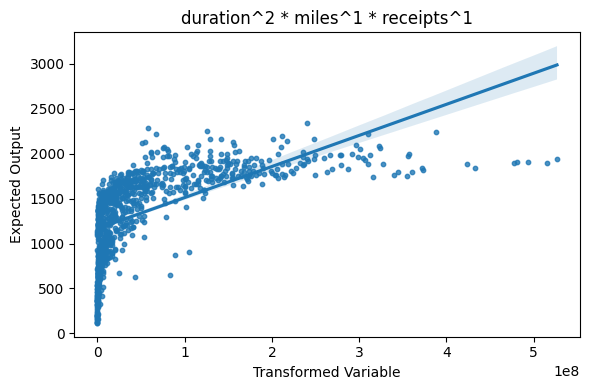

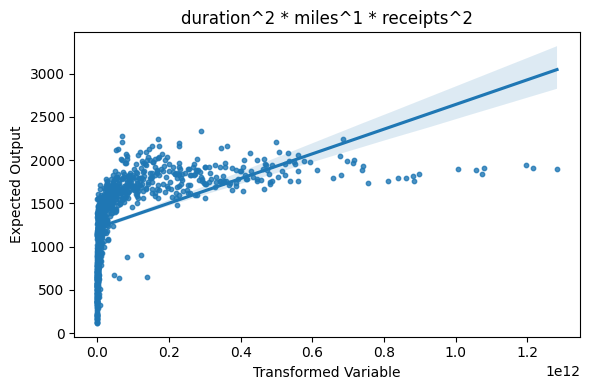

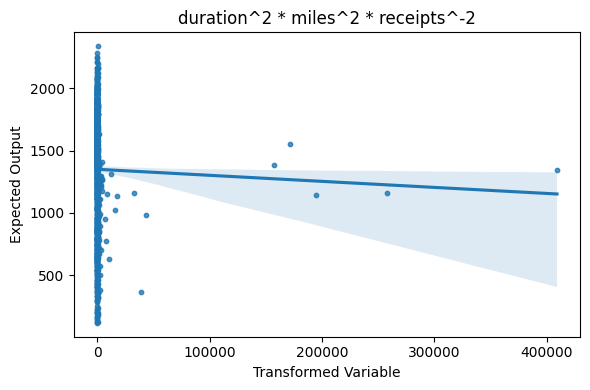

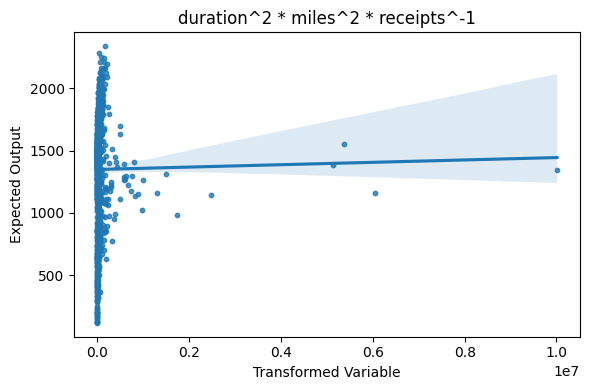

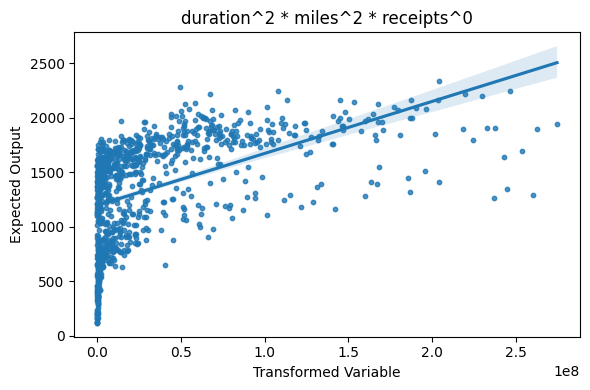

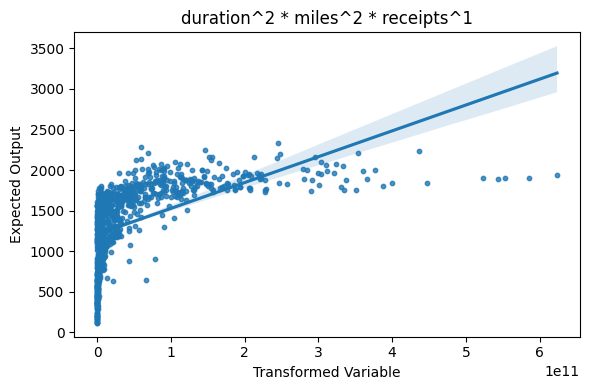

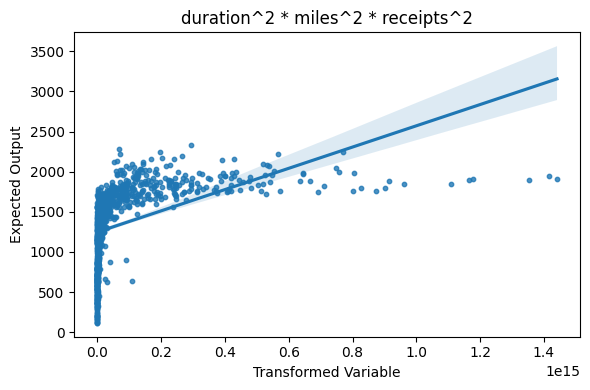

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np

# Make sure columns are float to handle negative powers
df['trip_duration_days'] = df['trip_duration_days'].astype(float)
df['miles_traveled'] = df['miles_traveled'].astype(float)
df['total_receipts_amount'] = df['total_receipts_amount'].astype(float)

# Define the range of degrees to consider
degrees = range(-2, 3)  # -2 to 2 inclusive

# Create all combinations of exponents for the 3 variables
combinations = list(itertools.product(degrees, repeat=3))

# Loop over each combination
for i, (d_exp, m_exp, r_exp) in enumerate(combinations):
    # Avoid invalid operations like dividing by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        # Calculate the transformed variable
        transformed = (
            np.power(df['trip_duration_days'], d_exp) *
            np.power(df['miles_traveled'], m_exp) *
            np.power(df['total_receipts_amount'], r_exp)
        )
        
        # Replace any NaN or inf values with 0 (optional)
        transformed = np.nan_to_num(transformed, nan=0.0, posinf=0.0, neginf=0.0)

        # Plot the regression
        plt.figure(figsize=(6, 4))
        sns.regplot(x=transformed, y=df['expected_output'], scatter_kws={'s': 10})
        plt.title(f'duration^{d_exp} * miles^{m_exp} * receipts^{r_exp}')
        plt.xlabel('Transformed Variable')
        plt.ylabel('Expected Output')
        plt.tight_layout()
        plt.show()


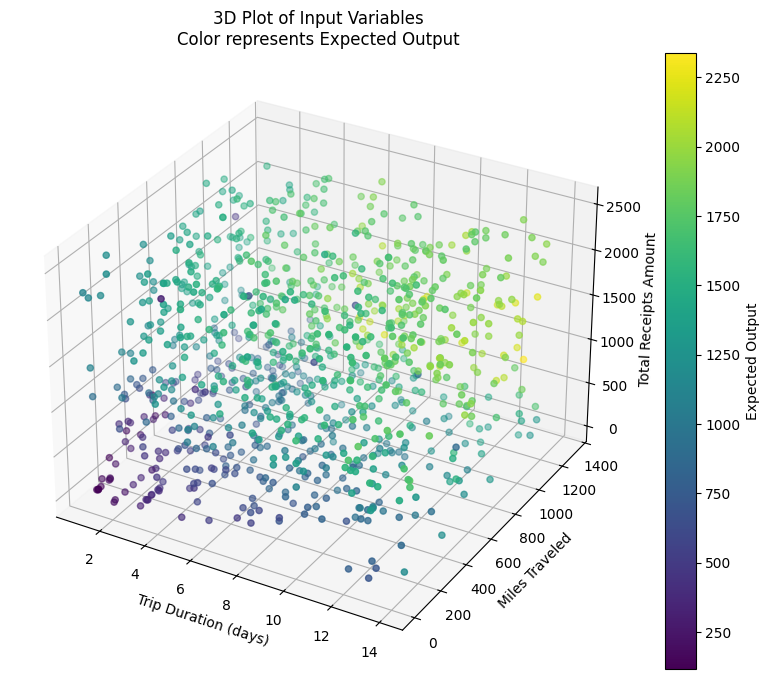

In [68]:
# make a 3d plot with color being the output
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(df['trip_duration_days'], 
                    df['miles_traveled'], 
                    df['total_receipts_amount'],
                    c=df['expected_output'],
                    cmap='viridis')

# Add labels and title
ax.set_xlabel('Trip Duration (days)')
ax.set_ylabel('Miles Traveled')
ax.set_zlabel('Total Receipts Amount')
ax.set_title('3D Plot of Input Variables\nColor represents Expected Output')

# Add a colorbar
plt.colorbar(scatter, label='Expected Output')

plt.show()


In [69]:
%pip install plotly 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
# make the 3d plot interactive
# Create an interactive 3D plot using plotly
import plotly.express as px

# Create the 3D scatter plot
fig = px.scatter_3d(df, 
                    x='trip_duration_days',
                    y='miles_traveled',
                    z='total_receipts_amount',
                    color='expected_output',
                    color_continuous_scale='viridis',
                    title='Interactive 3D Plot of Input Variables<br>Color represents Expected Output')

# Update layout
fig.update_layout(
    scene = dict(
        xaxis_title='Trip Duration (days)',
        yaxis_title='Miles Traveled',
        zaxis_title='Total Receipts Amount'
    ),
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()


# Analysis

In [153]:
from sklearn.model_selection import train_test_split

""" features_to_use = [
    'trip_duration_days', 'miles_traveled', 'total_receipts_amount',
    'miles_per_day', 'receipts_per_day', 'tiered_mileage_feature',
    'efficiency_bonus_flag', 'is_5_day_trip_flag', 'is_sweet_spot_duration_flag',
    'low_receipt_penalty_flag', 'cents_bug_flag', 'sweet_spot_combo_flag',
    'vacation_penalty_flag'
] """
# eatures_to_use = ['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'm/d', 'r/d', 'r^2', 'm^2', 'd*m', 'd^2*m^2', 'log(d*r)', 'log(m*r)', 'cents_bug_flag', 'is_more_than_5_day_trip_flag', 'is_5_day_trip_flag', 'is_8_day_trip_flag', 'log(r)']
features_to_use = ['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'm/d', 'r/d', 'r^2', 'm^2', 'd*m', 'log(d*r)', 'cents_bug_flag', 'log(r)']

X = df[features_to_use]
y = df['expected_output']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = X, X, y, y # for testing
 

In [154]:
len(features_to_use)

11

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}")

# print out the linear regression model
print("Linear Regression Coefficients:")
for feature, coef in zip(features_to_use, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"\nIntercept: {model.intercept_:.4f}")
# Save the model coefficients to a CSV file
# Save the model coefficients to a CSV file
coefficients_df = pd.DataFrame({
    'feature': features_to_use,
    'coefficient': model.coef_
})
# add a row for the intercept
coefficients_df.to_csv('linear_regression_coefficients.csv', index=False)

# read the csv file and add a row for the intercept
with open('linear_regression_coefficients.csv', 'a') as f:
    f.write('intercept,')
    f.write(str(model.intercept_))
    f.write('\n')



Linear Regression MSE: 17240.39
Linear Regression Coefficients:
trip_duration_days: 11.2826
miles_traveled: 0.5533
total_receipts_amount: 1.4550
m/d: -0.1402
r/d: 0.1385
r^2: -0.0004
m^2: -0.0001
d*m: 0.0016
log(d*r): 220.4648
cents_bug_flag: -456.3037
log(r): -339.4875

Intercept: 414.1591


In [156]:
# graph every feature against the error

In [173]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

print(f"Tree MSE: {mean_squared_error(y_test, tree.predict(X_test)):.2f}")

# save the tree to a file
import pickle

# Save the tree model to a file
with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(tree, f)



Tree MSE: 13364.77


In [ ]:
import numpy as np

import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

print(f"XGBoost MSE: {mean_squared_error(y_test, xgb_model.predict(X_test)):.2f}")


preds = xgb_model.predict(X_test).round()
match_rate = np.mean(preds == y_test)
print(f"Exact Match Rate: {match_rate*100:.2f}%")


XGBoost MSE: 37021.89
Exact Match Rate: 0.00%


In [159]:
import numpy as np
import pandas as pd

# Assume df, X, y, X_test, y_test, and xgb_model are already defined from your previous cells

# Get a random test case
random_idx = np.random.randint(0, len(X_test))
random_case = X_test.iloc[random_idx]
random_output = y_test.iloc[random_idx]

# Calculate Euclidean distance for all cases
distances = np.sqrt(
    ((X['trip_duration_days'] - random_case['trip_duration_days'])**2) +
    ((X['miles_traveled'] - random_case['miles_traveled'])**2) +
    ((X['total_receipts_amount'] - random_case['total_receipts_amount'])**2)
)

# Get indices of 5 closest cases
closest_indices = np.argsort(distances)[1:6]  # Skip first (self) and get next 5

# --- Print results with the corrected prediction call ---
print(f"Random case (Index: {random_case.name}):")
print(f"Trip Duration: {random_case['trip_duration_days']:.1f} days")
print(f"Miles Traveled: {random_case['miles_traveled']:.1f}")
print(f"Total Receipts: ${random_case['total_receipts_amount']:.2f}")
print(f"Expected Output: ${random_output:.2f}")

# --- FIX IS HERE ---
# Reshape the 1D Series to a 2D DataFrame for prediction
prediction_input = random_case.to_frame().T
print(f"XGBoost Prediction: ${xgb_model.predict(prediction_input).round(2)[0]:.2f}")
# --- END FIX ---

print("\n5 Closest Cases:")
print("-" * 50)

for idx in closest_indices:
    case = X.iloc[idx]
    output = df['expected_output'].iloc[idx]
    distance = distances[idx]
    print(f"Case Index: {case.name}")
    print(f"Trip Duration: {case['trip_duration_days']:.1f} days")
    print(f"Miles Traveled: {case['miles_traveled']:.1f}")
    print(f"Total Receipts: ${case['total_receipts_amount']:.2f}")
    print(f"Expected Output: ${output:.2f}")
    
    # --- FIX IS HERE ---
    # Also apply the fix inside the loop
    prediction_input_loop = case.to_frame().T
    print(f"XGBoost Prediction: ${xgb_model.predict(prediction_input_loop).round(2)[0]:.2f}")
    # --- END FIX ---

    print(f"Distance: {distance:.2f}")
    print("-" * 50)

Random case (Index: 937):
Trip Duration: 9.0 days
Miles Traveled: 934.0
Total Receipts: $415.50
Expected Output: $1208.82
XGBoost Prediction: $1224.91

5 Closest Cases:
--------------------------------------------------
Case Index: 439
Trip Duration: 11.0 days
Miles Traveled: 960.0
Total Receipts: $383.64
Expected Output: $1248.46
XGBoost Prediction: $1274.72
Distance: 41.17
--------------------------------------------------
Case Index: 756
Trip Duration: 5.0 days
Miles Traveled: 919.0
Total Receipts: $470.23
Expected Output: $1119.17
XGBoost Prediction: $1079.52
Distance: 56.89
--------------------------------------------------
Case Index: 509
Trip Duration: 2.0 days
Miles Traveled: 875.0
Total Receipts: $393.25
Expected Output: $640.56
XGBoost Prediction: $689.54
Distance: 63.44
--------------------------------------------------
Case Index: 679
Trip Duration: 3.0 days
Miles Traveled: 870.0
Total Receipts: $413.23
Expected Output: $795.80
XGBoost Prediction: $767.71
Distance: 64.32
--

--- Linear Regression Analysis ---
Linear Regression Coefficients:
                       Coefficient
cents_bug_flag          -13.689112
log(r)                -2289.833822
log(d*r)               1867.485635
trip_duration_days       79.463392
total_receipts_amount  1762.033792
miles_traveled          330.528291
m/d                     -20.611985
r/d                      39.566807
d*m                       6.861806
r^2                    -780.167509
m^2                     -46.682322

Intercept: 414.16

--- XGBoost Analysis ---



XGBoost Feature Importances:
                       Importance
total_receipts_amount    0.449774
d*m                      0.248605
log(d*r)                 0.134010
cents_bug_flag           0.121783
miles_traveled           0.015600
trip_duration_days       0.010972
m/d                      0.010411
r/d                      0.008845
r^2                      0.000000
m^2                      0.000000
log(r)                   0.000000


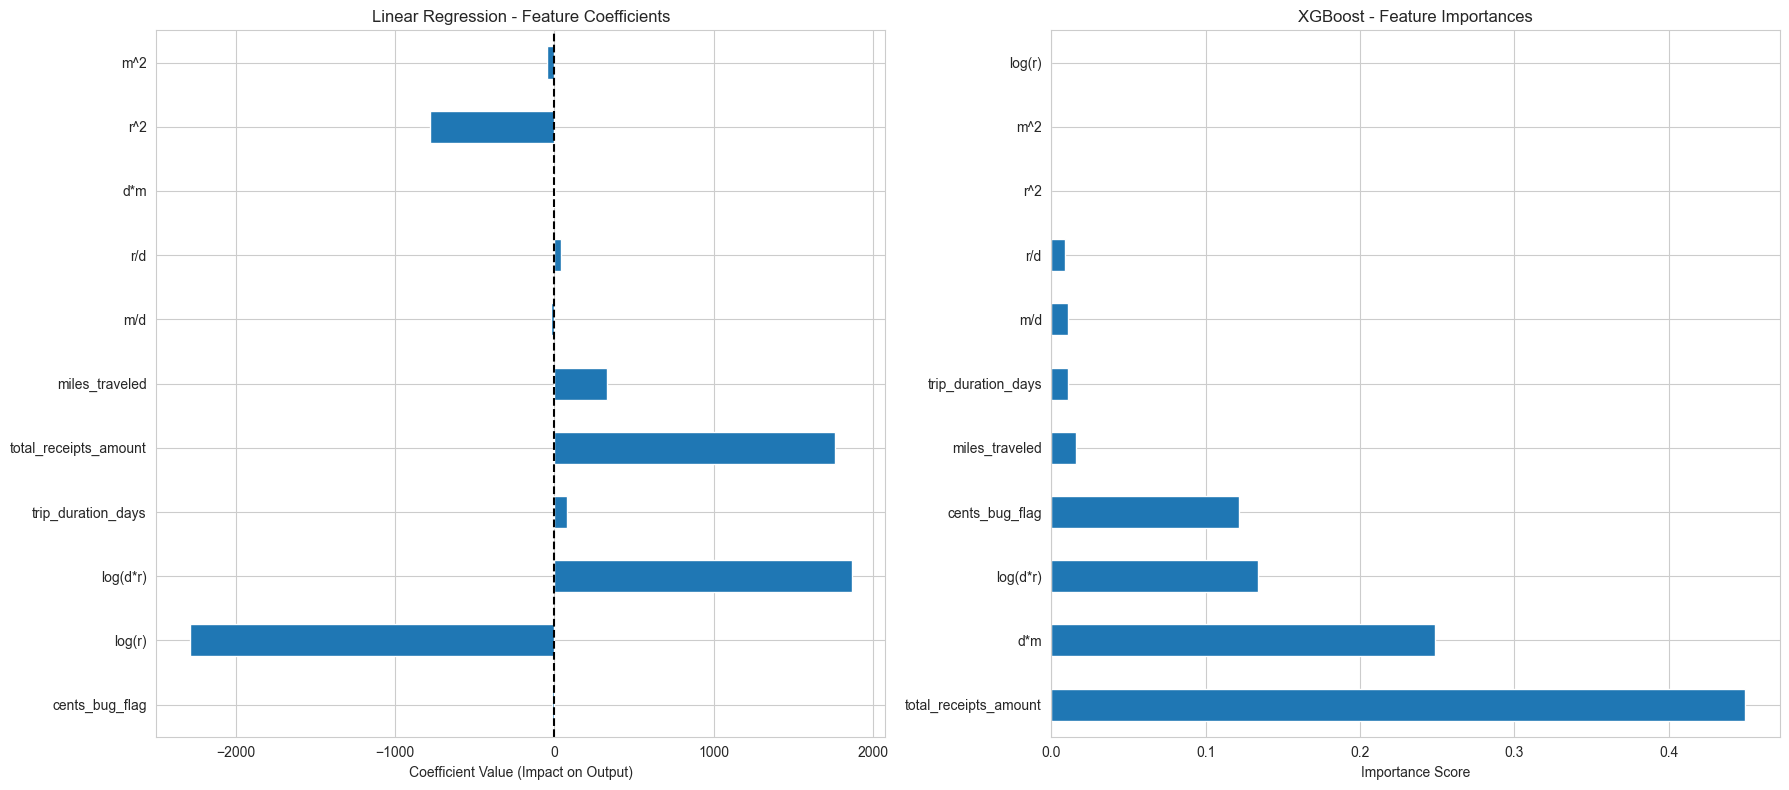

In [160]:
# --- 1. Linear Regression Coefficient Analysis ---
print("--- Linear Regression Analysis ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Create a DataFrame of coefficients
lr_coeffs = pd.DataFrame(
    lr_model.coef_,
    columns=['Coefficient'],
    index=X_train.columns
)
# Sort by the absolute value of the coefficient to see the magnitude of impact
lr_coeffs = lr_coeffs.reindex(lr_coeffs.Coefficient.abs().sort_values(ascending=False).index)
# multiply the coefficients by the mean of the feature
lr_coeffs['Coefficient'] = lr_coeffs['Coefficient'] * X_train.mean()
print("Linear Regression Coefficients:")
print(lr_coeffs)
print(f"\nIntercept: {lr_model.intercept_:.2f}")


# --- 2. XGBoost Feature Importance Analysis ---
print("\n--- XGBoost Analysis ---")
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Create a DataFrame of feature importances
xgb_importances = pd.DataFrame(
    xgb_model.feature_importances_,
    columns=['Importance'],
    index=X_train.columns
).sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importances:")
print(xgb_importances)

# --- 3. Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Plot Linear Regression Coefficients
lr_coeffs.plot(kind='barh', ax=ax1, legend=None)
ax1.set_title('Linear Regression - Feature Coefficients')
ax1.set_xlabel('Coefficient Value (Impact on Output)')
ax1.axvline(0, color='black', linestyle='--')

# Plot XGBoost Feature Importances
xgb_importances.plot(kind='barh', ax=ax2, legend=None)
ax2.set_title('XGBoost - Feature Importances')
ax2.set_xlabel('Importance Score')

plt.tight_layout()
plt.show()


In [161]:
%pip install dtreeviz

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
X = df[features_to_use]
df['predicted_output'] = xgb_model.predict(X)

# Calculate the error (also called the residual)
# A positive error means the prediction was lower than the actual output.
# A negative error means the prediction was higher than the actual output.
df['prediction_error'] = df['expected_output'] - df['predicted_output']

# Label each row as belonging to the 'Train' or 'Test' set for better visualization
df['Set'] = 'Train'
df.loc[X_test.index, 'Set'] = 'Test'


# --- Step 2: Create the Interactive 3D Plot ---

print("Generating interactive plot... The color represents prediction error.")
print("Blue points: Model predicted HIGHER than actual (error < 0)")
print("Red points: Model predicted LOWER than actual (error > 0)")


# Create the 3D scatter plot using plotly
fig = px.scatter_3d(
    df, # only show data with prediction error > 100
    # df[abs(df['prediction_error']) > 50],
    x='trip_duration_days',
    y='miles_traveled',
    z='total_receipts_amount',
    color='prediction_error',
    symbol='Set',  # Use different shapes for Train vs. Test data
    color_continuous_scale=px.colors.diverging.RdBu,  # Red-Blue scale is great for errors
    color_continuous_midpoint=0,  # Center the color scale at zero error
    title='Interactive 3D Plot of XGBoost Prediction Errors',
    # Add custom data to see on hover for detailed analysis
    hover_data={
        'expected_output': ':.2f',
        'predicted_output': ':.2f',
        'prediction_error': ':.2f'
    }
)

# --- Step 3: Update Layout and Display ---

# Update layout for clarity
fig.update_layout(
    scene=dict(
        xaxis_title='Trip Duration (days)',
        yaxis_title='Miles Traveled',
        zaxis_title='Total Receipts Amount'
    ),
    legend_title_text='Data Set',
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()


Generating interactive plot... The color represents prediction error.
Blue points: Model predicted HIGHER than actual (error < 0)
Red points: Model predicted LOWER than actual (error > 0)


In [164]:
# Save to a csv file
# df[abs(df['prediction_error']) > 50]

df[abs(df['prediction_error']) > 50].to_csv('prediction_errors.csv', index=False)

In [165]:
X = df[features_to_use]
df['predicted_output'] = model.predict(X)

# Calculate the error (also called the residual)
# A positive error means the prediction was lower than the actual output.
# A negative error means the prediction was higher than the actual output.
df['prediction_error_linear'] = df['expected_output'] - df['predicted_output']

# Label each row as belonging to the 'Train' or 'Test' set for better visualization
df['Set'] = 'Train'
df.loc[X_test.index, 'Set'] = 'Test'


# --- Step 2: Create the Interactive 3D Plot ---

print("Generating interactive plot... The color represents prediction error.")
print("Blue points: Model predicted HIGHER than actual (error < 0)")
print("Red points: Model predicted LOWER than actual (error > 0)")


# Create the 3D scatter plot using plotly
fig = px.scatter_3d(
    df, # only show data with prediction error > 100
    # df[abs(df['prediction_error_linear']) > 100],
    x='trip_duration_days',
    y='miles_traveled',
    z='total_receipts_amount',
    color='prediction_error_linear',
    symbol='Set',  # Use different shapes for Train vs. Test data
    color_continuous_scale=px.colors.diverging.RdBu,  # Red-Blue scale is great for errors
    color_continuous_midpoint=0,  # Center the color scale at zero error
    title='Interactive 3D Plot of Regression Prediction Errors',
    # Add custom data to see on hover for detailed analysis
    hover_data={
        'expected_output': ':.2f',
        'predicted_output': ':.2f',
        'prediction_error_linear': ':.2f'
    }
)

# --- Step 3: Update Layout and Display ---

# Update layout for clarity
fig.update_layout(
    scene=dict(
        xaxis_title='Trip Duration (days)',
        yaxis_title='Miles Traveled',
        zaxis_title='Total Receipts Amount'
    ),
    legend_title_text='Data Set',
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()


Generating interactive plot... The color represents prediction error.
Blue points: Model predicted HIGHER than actual (error < 0)
Red points: Model predicted LOWER than actual (error > 0)


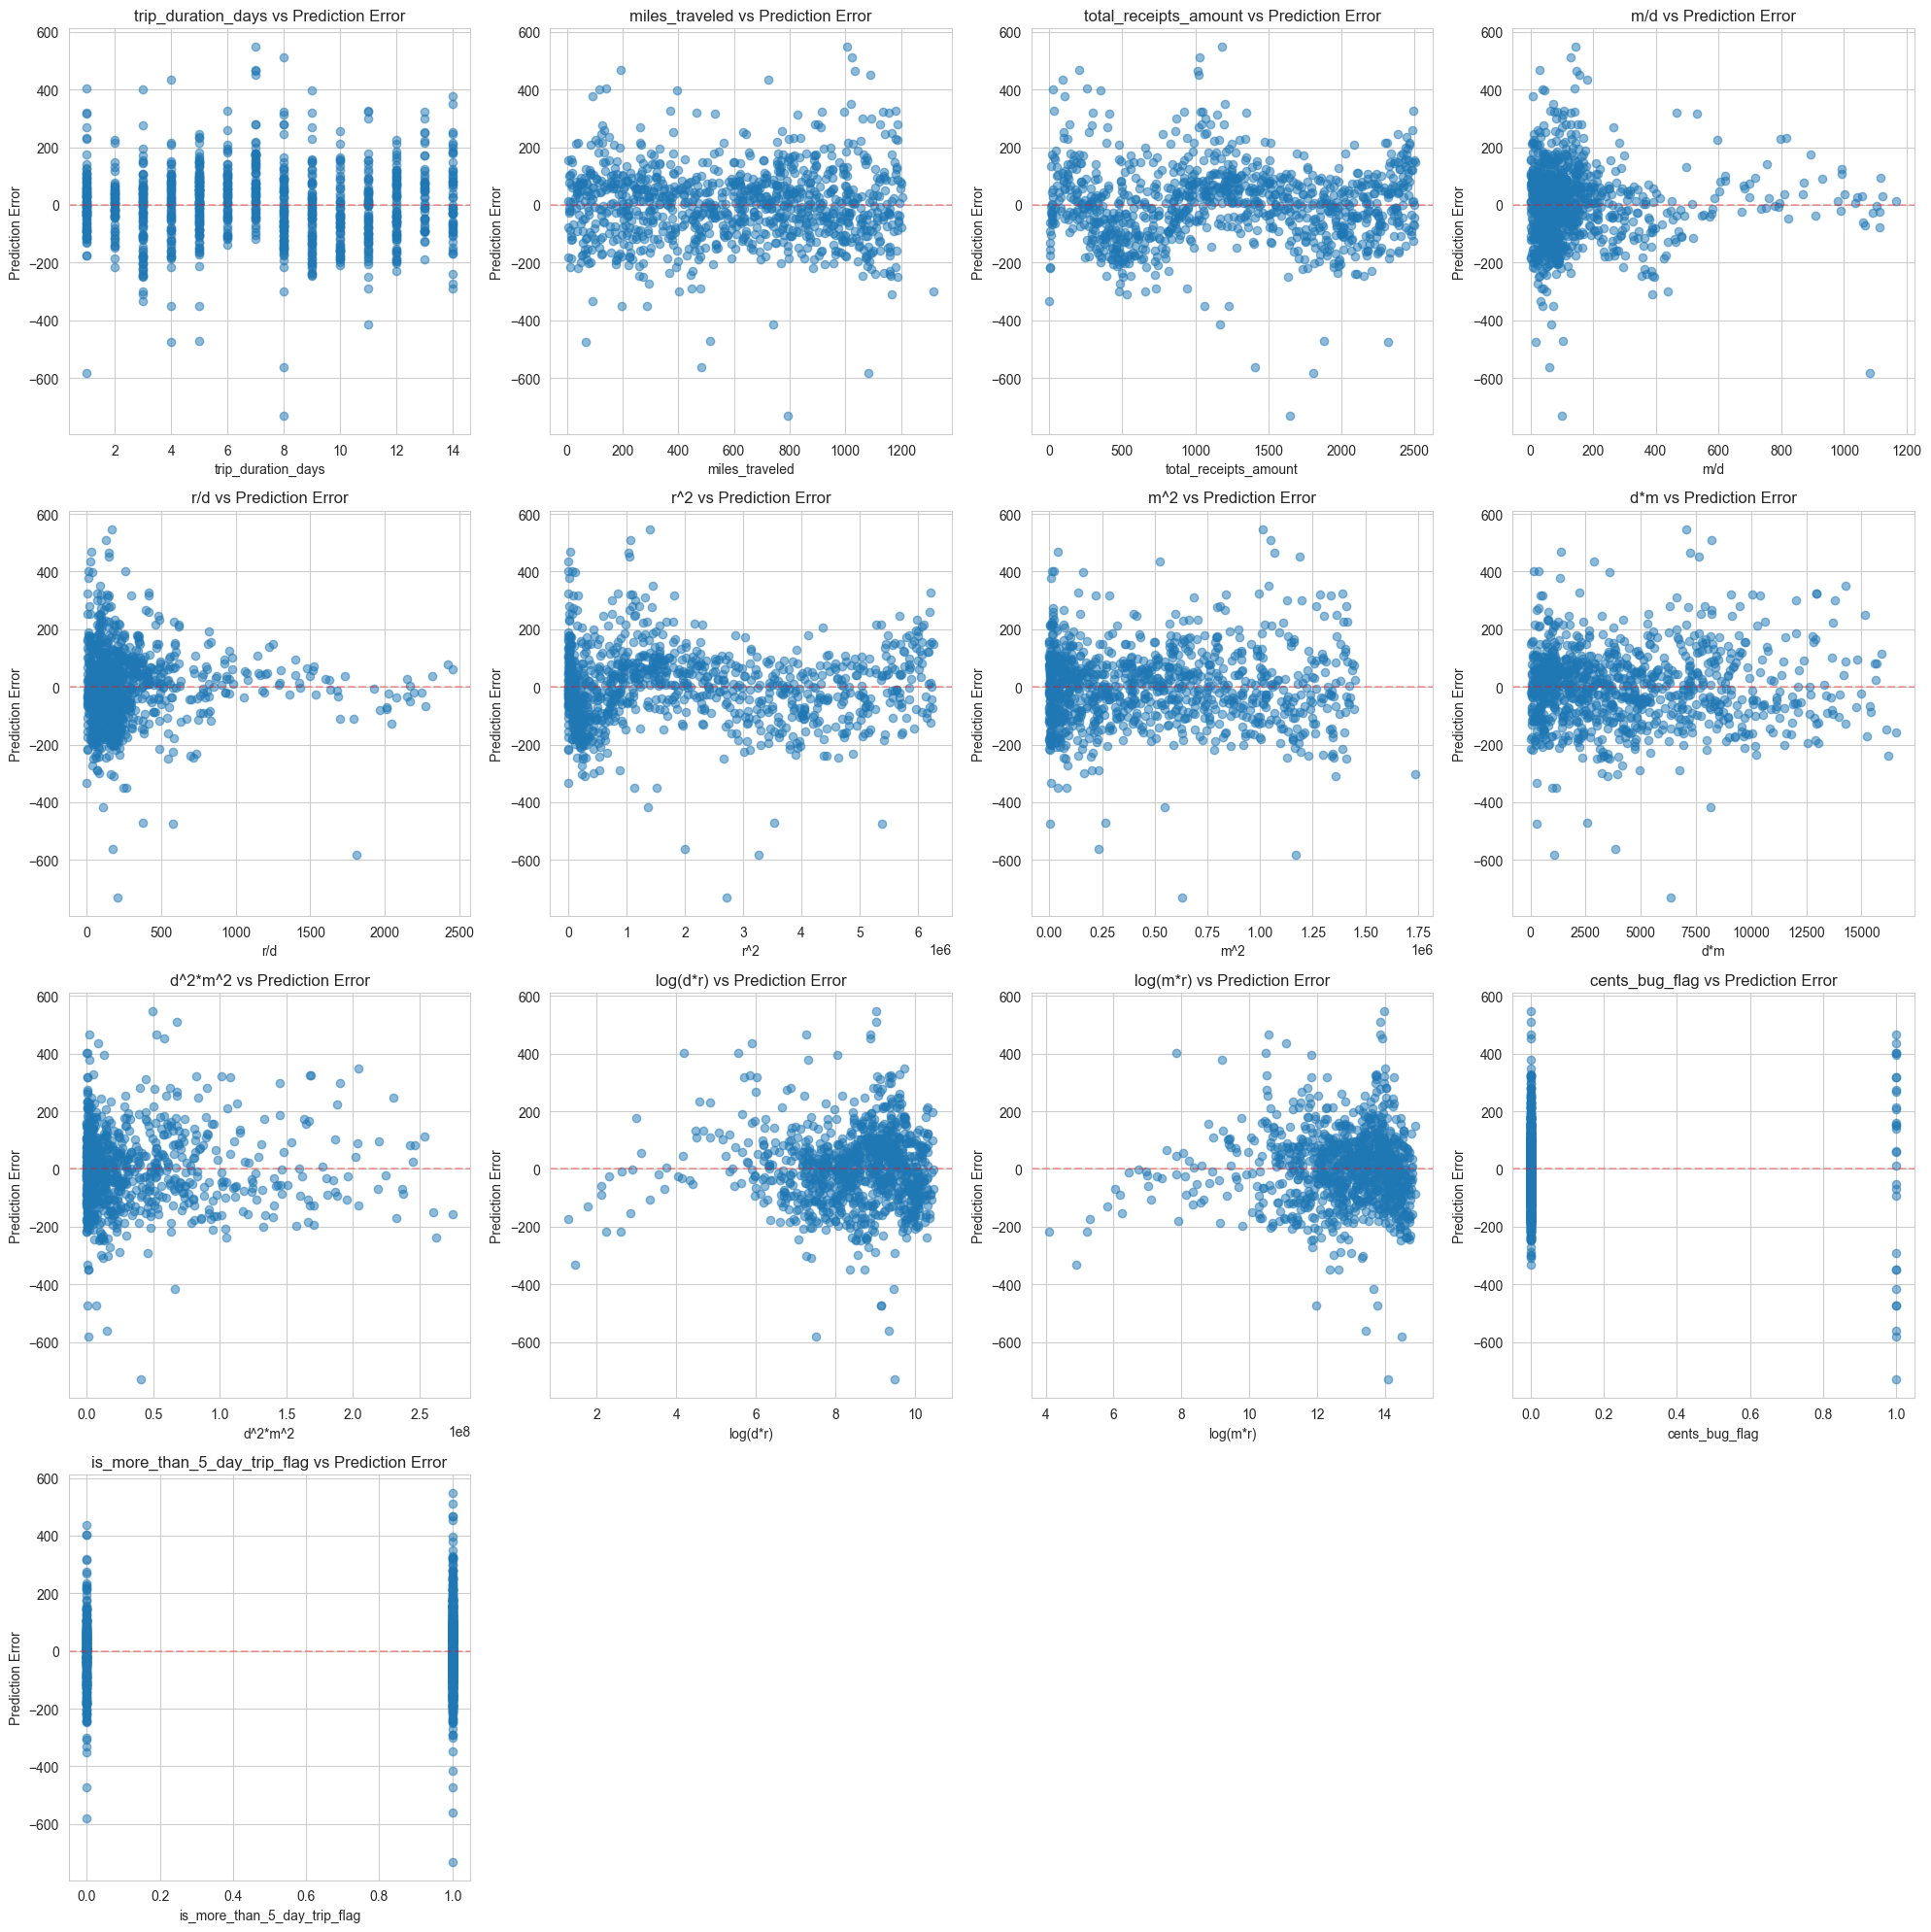

In [171]:
# graph every feature against the error for the linear regression model
# Create a figure with subplots for each feature
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# List of features to plot
features = [
    'trip_duration_days', 'miles_traveled', 'total_receipts_amount',
    'm/d', 'r/d', 'r^2', 'm^2', 'd*m', 'd^2*m^2',
    'log(d*r)', 'log(m*r)', 'cents_bug_flag',
    'is_more_than_5_day_trip_flag'
]

# Plot each feature against prediction error
for idx, feature in enumerate(features):
    if idx < len(axes):
        ax = axes[idx]
        ax.scatter(df[feature], df['prediction_error_linear'], alpha=0.5)
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        ax.set_xlabel(feature)
        ax.set_ylabel('Prediction Error')
        ax.set_title(f'{feature} vs Prediction Error')

# Remove any empty subplots
for idx in range(len(features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [172]:
# --- 4. Print a Single XGBoost Decision Tree as Text ---
print("\n--- Text Dump of the First Decision Tree from the XGBoost Model ---")
print("This output shows the raw 'if/then' splits of the tree.\n")

# get_dump() returns a list of strings, where each string is one tree.
# This method requires no external dependencies like Graphviz.
tree_dump_list = xgb_model.get_booster().get_dump()

# Print the first tree from the list
print(f"--- Tree 0 ---\n{tree_dump_list[0]}")



--- Text Dump of the First Decision Tree from the XGBoost Model ---
This output shows the raw 'if/then' splits of the tree.

--- Tree 0 ---
0:[total_receipts_amount<841.109985] yes=1,no=2,missing=2
	1:[d*m<2076] yes=3,no=4,missing=4
		3:[log(d*r)<6.3324976] yes=7,no=8,missing=8
			7:[d*m<548] yes=15,no=16,missing=16
				15:leaf=-104.291679
				16:leaf=-73.27491
			8:[log(d*r)<8.73454762] yes=17,no=18,missing=18
				17:[d*m<1310] yes=29,no=30,missing=30
					29:leaf=-71.6952438
					30:leaf=-53.4415894
				18:[trip_duration_days<13] yes=31,no=32,missing=32
					31:leaf=-20.9710522
					32:leaf=-5.88459921
		4:[d*m<4980] yes=9,no=10,missing=10
			9:[total_receipts_amount<631.880005] yes=19,no=20,missing=20
				19:[log(d*r)<7.41965055] yes=33,no=34,missing=34
					33:leaf=-54.5078506
					34:leaf=-40.3664131
				20:[total_receipts_amount<749.559998] yes=35,no=36,missing=36
					35:leaf=-23.0975323
					36:leaf=-9.35748672
			10:[total_receipts_amount<462.790009] yes=21,no=22,missing=22
	

In [168]:
# save the xgb model to a file
import joblib

# Save the XGBoost model to a file
joblib.dump(xgb_model, 'xgb_model.joblib')

print("Model saved successfully to 'xgb_model.joblib'")


Model saved successfully to 'xgb_model.joblib'


In [169]:
# load the xgb model from a file
# and predict the output for the given input
# echo "Input: $1 days, $2 miles, \$$3 receipts"
# python calculate_reimbursement.py "$1" "$2" "$3"